In [1]:
# !pip install warmup_scheduler
# !pip install torchlibrosa
# !pip install audiomentations

In [2]:
import librosa

In [3]:
from audiomentations import *

In [4]:
import noisereduce as nr

/home/simon/miniconda3/envs/kaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch
import pandas as pd
import os
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler
from timm.scheduler import CosineLRScheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import copy
import time
import os
import timm
import random
import numpy as np
import gc
import torch
import torchaudio
import torchvision
from sklearn.model_selection import StratifiedKFold
# from metrics import calculate_competition_metrics, metrics_to_string, calculate_competition_metrics_no_map
from warmup_scheduler import GradualWarmupScheduler
from torch.optim import AdamW
import albumentations as A
import matplotlib.pyplot as plt
from pylab import rcParams

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse as ifilterfalse

import sklearn
import warnings
warnings.filterwarnings("ignore")


In [6]:
def padded_cmap(solution, submission, padding_factor=5):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

def padded_auc(solution, submission, padding_factor=5):
    solution = solution #.drop(['row_id'], axis=1, errors='ignore')
    submission = submission #.drop(['row_id'], axis=1, errors='ignore')


    solution_sums = solution.sum(axis=0)
    scored_columns = list(solution_sums[solution_sums > 0].index.values)
#     assert len(scored_columns) > 0

    return sklearn.metrics.roc_auc_score(solution[scored_columns].values, submission[scored_columns].values, average='macro')

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Version of macro-averaged ROC-AUC score that ignores all classes that have no true positive labels.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    solution_sums = solution.sum(axis=0)
    scored_columns = list(solution_sums[solution_sums > 0].index.values)
#     assert len(scored_columns) > 0

    return sklearn.metrics.roc_auc_score(solution[scored_columns].values, submission[scored_columns].values, average='macro')

def calculate_competition_metrics(gt, preds, target_columns, one_hot=True):
    if not one_hot:
        ground_truth = np.argmax(gt, axis=1)
        gt = np.zeros((ground_truth.size, len(target_columns)))
        gt[np.arange(ground_truth.size), ground_truth] = 1
    val_df = pd.DataFrame(gt, columns=target_columns)
    pred_df = pd.DataFrame(preds, columns=target_columns)
    cmAP_1 = padded_cmap(val_df, pred_df, padding_factor=1)
    cmAP_5 = padded_cmap(val_df, pred_df, padding_factor=5)
    val_df['id'] = [f'id_{i}' for i in range(len(val_df))]
    pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
    train_score = score(val_df, pred_df, row_id_column_name='id')
    return {
      "cmAP_1": cmAP_1,
      "cmAP_5": cmAP_5,
      "ROC": train_score,
    }
def metrics_to_string(scores, key_word):
    log_info = ""
    for key in scores.keys():
        log_info = log_info + f"{key_word} {key} : {scores[key]:.4f}, "
    return log_info

## Training Logs

Epoch 1 - Train loss: 0.8522, Train cmAP_1 : 0.5357, Train cmAP_5 : 0.7442, 
Epoch 1 - Valid loss: 0.8485, Valid cmAP_1 : 0.1220, Valid cmAP_5 : 0.3257, Valid mAP : 0.0082, Valid ROC : 0.5372, 
Epoch 1 - Save Best Score: 0.5372 Model

Epoch 2 - Train loss: 0.7673, Train cmAP_1 : 0.5354, Train cmAP_5 : 0.7419, 
Epoch 2 - Valid loss: 0.6464, Valid cmAP_1 : 0.1235, Valid cmAP_5 : 0.3270, Valid mAP : 0.0129, Valid ROC : 0.5611, 
Epoch 2 - Save Best Score: 0.5611 Model

Epoch 3 - Train loss: 0.3128, Train cmAP_1 : 0.5624, Train cmAP_5 : 0.7448, 
Epoch 3 - Valid loss: 0.1051, Valid cmAP_1 : 0.0590, Valid cmAP_5 : 0.2511, Valid mAP : 0.0226, Valid ROC : 0.6110, 
Epoch 3 - Save Best Score: 0.6110 Model

Epoch 4 - Train loss: 0.0411, Train cmAP_1 : 0.5409, Train cmAP_5 : 0.7417, 
Epoch 4 - Valid loss: 0.0401, Valid cmAP_1 : 0.1435, Valid cmAP_5 : 0.3504, Valid mAP : 0.0463, Valid ROC : 0.7263, 
Epoch 4 - Save Best Score: 0.7263 Model

Epoch 5 - Train loss: 0.0350, Train cmAP_1 : 0.5427, Train cmAP_5 : 0.7459, 
Epoch 5 - Valid loss: 0.0328, Valid cmAP_1 : 0.2460, Valid cmAP_5 : 0.4553, Valid mAP : 0.2485, Valid ROC : 0.8743, 
Epoch 5 - Save Best Score: 0.8743 Model

Epoch 6 - Train loss: 0.0288, Train cmAP_1 : 0.5864, Train cmAP_5 : 0.7732, 
Epoch 6 - Valid loss: 0.0261, Valid cmAP_1 : 0.3153, Valid cmAP_5 : 0.5258, Valid mAP : 0.3372, Valid ROC : 0.9202, 
Epoch 6 - Save Best Score: 0.9202 Model

Epoch 7 - Train loss: 0.0256, Train cmAP_1 : 0.5644, Train cmAP_5 : 0.7617, 
Epoch 7 - Valid loss: 0.0274, Valid cmAP_1 : 0.3493, Valid cmAP_5 : 0.5602, Valid mAP : 0.3776, Valid ROC : 0.9380, 
Epoch 7 - Save Best Score: 0.9380 Model

Epoch 8 - Train loss: 0.0236, Train cmAP_1 : 0.5792, Train cmAP_5 : 0.7725, 
Epoch 8 - Valid loss: 0.0198, Valid cmAP_1 : 0.4676, Valid cmAP_5 : 0.6471, Valid mAP : 0.5536, Valid ROC : 0.9509, 
Epoch 8 - Save Best Score: 0.9509 Model

Epoch 9 - Train loss: 0.0223, Train cmAP_1 : 0.6052, Train cmAP_5 : 0.7826, 
Epoch 9 - Valid loss: 0.0202, Valid cmAP_1 : 0.4754, Valid cmAP_5 : 0.6594, Valid mAP : 0.5519, Valid ROC : 0.9569, 
Epoch 9 - Save Best Score: 0.9569 Model

Epoch 10 - Train loss: 0.0217, Train cmAP_1 : 0.5950, Train cmAP_5 : 0.7810, 
Epoch 10 - Valid loss: 0.0198, Valid cmAP_1 : 0.4619, Valid cmAP_5 : 0.6518, Valid mAP : 0.5328, Valid ROC : 0.9592, 
Epoch 10 - Save Best Score: 0.9592 Model

Epoch 11 - Train loss: 0.0202, Train cmAP_1 : 0.6104, Train cmAP_5 : 0.7915, 
Epoch 11 - Valid loss: 0.0166, Valid cmAP_1 : 0.5612, Valid cmAP_5 : 0.7150, Valid mAP : 0.6656, Valid ROC : 0.9641, 
Epoch 11 - Save Best Score: 0.9641 Model

Epoch 12 - Train loss: 0.0197, Train cmAP_1 : 0.5942, Train cmAP_5 : 0.7841, 
Epoch 12 - Valid loss: 0.0162, Valid cmAP_1 : 0.5966, Valid cmAP_5 : 0.7349, Valid mAP : 0.6805, Valid ROC : 0.9634, 
Valid loss didn't improve last 1 epochs.

Epoch 13 - Train loss: 0.0192, Train cmAP_1 : 0.5937, Train cmAP_5 : 0.7795, 
Epoch 13 - Valid loss: 0.0159, Valid cmAP_1 : 0.6153, Valid cmAP_5 : 0.7457, Valid mAP : 0.6893, Valid ROC : 0.9669, 
Epoch 13 - Save Best Score: 0.9669 Model

Epoch 14 - Train loss: 0.0191, Train cmAP_1 : 0.5991, Train cmAP_5 : 0.7903, 
Epoch 14 - Valid loss: 0.0193, Valid cmAP_1 : 0.5310, Valid cmAP_5 : 0.7047, Valid mAP : 0.5732, Valid ROC : 0.9660, 
Valid loss didn't improve last 1 epochs.

Epoch 15 - Train loss: 0.0180, Train cmAP_1 : 0.6038, Train cmAP_5 : 0.7822, 
Epoch 15 - Valid loss: 0.0163, Valid cmAP_1 : 0.5753, Valid cmAP_5 : 0.7283, Valid mAP : 0.6613, Valid ROC : 0.9656, 
Valid loss didn't improve last 2 epochs.

Epoch 16 - Train loss: 0.0181, Train cmAP_1 : 0.6067, Train cmAP_5 : 0.7918, 
Epoch 16 - Valid loss: 0.0168, Valid cmAP_1 : 0.5555, Valid cmAP_5 : 0.7140, Valid mAP : 0.6448, Valid ROC : 0.9613, 
Valid loss didn't improve last 3 epochs.

Epoch 17 - Train loss: 0.0176, Train cmAP_1 : 0.6181, Train cmAP_5 : 0.7918, 
Epoch 17 - Valid loss: 0.0160, Valid cmAP_1 : 0.5999, Valid cmAP_5 : 0.7436, Valid mAP : 0.6738, Valid ROC : 0.9670, 
Epoch 17 - Save Best Score: 0.9670 Model

Epoch 18 - Train loss: 0.0169, Train cmAP_1 : 0.6040, Train cmAP_5 : 0.7897, 
Epoch 18 - Valid loss: 0.0174, Valid cmAP_1 : 0.5920, Valid cmAP_5 : 0.7447, Valid mAP : 0.6454, Valid ROC : 0.9690, 
Epoch 18 - Save Best Score: 0.9690 Model

Epoch 19 - Train loss: 0.0162, Train cmAP_1 : 0.6005, Train cmAP_5 : 0.7870, 
Epoch 19 - Valid loss: 0.0174, Valid cmAP_1 : 0.5855, Valid cmAP_5 : 0.7397, Valid mAP : 0.6386, Valid ROC : 0.9682, 
Valid loss didn't improve last 1 epochs.

Epoch 20 - Train loss: 0.0161, Train cmAP_1 : 0.6355, Train cmAP_5 : 0.8080, 
Epoch 20 - Valid loss: 0.0151, Valid cmAP_1 : 0.6357, Valid cmAP_5 : 0.7629, Valid mAP : 0.7092, Valid ROC : 0.9683, 
Valid loss didn't improve last 2 epochs.

Epoch 21 - Train loss: 0.0157, Train cmAP_1 : 0.6019, Train cmAP_5 : 0.7856, 
Epoch 21 - Valid loss: 0.0162, Valid cmAP_1 : 0.5980, Valid cmAP_5 : 0.7464, Valid mAP : 0.6594, Valid ROC : 0.9675, 
Valid loss didn't improve last 3 epochs.

Epoch 22 - Train loss: 0.0160, Train cmAP_1 : 0.5569, Train cmAP_5 : 0.7717, 
Epoch 22 - Valid loss: 0.0148, Valid cmAP_1 : 0.6402, Valid cmAP_5 : 0.7668, Valid mAP : 0.7204, Valid ROC : 0.9673, 
Valid loss didn't improve last 4 epochs.

Epoch 23 - Train loss: 0.0158, Train cmAP_1 : 0.6211, Train cmAP_5 : 0.8011, 
Epoch 23 - Valid loss: 0.0150, Valid cmAP_1 : 0.6254, Valid cmAP_5 : 0.7594, Valid mAP : 0.7124, Valid ROC : 0.9642, 
Valid loss didn't improve last 5 epochs.

Epoch 24 - Train loss: 0.0153, Train cmAP_1 : 0.5914, Train cmAP_5 : 0.7817, 
Epoch 24 - Valid loss: 0.0154, Valid cmAP_1 : 0.6207, Valid cmAP_5 : 0.7590, Valid mAP : 0.6824, Valid ROC : 0.9650, 
Valid loss didn't improve last 6 epochs.

Epoch 25 - Train loss: 0.0143, Train cmAP_1 : 0.6056, Train cmAP_5 : 0.7859, 
Epoch 25 - Valid loss: 0.0155, Valid cmAP_1 : 0.6094, Valid cmAP_5 : 0.7542, Valid mAP : 0.6769, Valid ROC : 0.9680, 
Valid loss didn't improve last 7 epochs.

Early stop, Training End.


In [7]:
exp_name = 'exp2'
# backbone = 'eca_nfnet_l0'
seed = 42
batch_size =  64
num_workers = 12

n_epochs = 50
warmup_epo = 5
cosine_epo = n_epochs - warmup_epo

image_size = 256 #128 #256

lr_max = 1e-5
lr_min = 1e-7
weight_decay = 1e-6

# mel_spec_params = {
#     "sample_rate": 32000,
#     "n_mels": 128,
#     "f_min": 20,
#     "f_max": 16000,
#     "n_fft": 1024,
#     "hop_length": 320,
#     "normalized": True,
#     "center" : True,
#     "pad_mode" : "constant",
#     "norm" : "slaney",
#     "onesided" : True,
#     "mel_scale" : "slaney"
# }

mel_spec_params = {
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 500,
    "f_max": 10000,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
    "center" : True,
    "pad_mode" : "constant",
    "norm" : "slaney",
    "onesided" : True,
    "mel_scale" : "slaney"
}

top_db = 80
train_period = 5
val_period = 5

secondary_coef = 1.0

train_duration = train_period * mel_spec_params["sample_rate"]
val_duration = val_period * mel_spec_params["sample_rate"]

N_FOLD = 5
fold = 2

use_amp = True
max_grad_norm = 10
early_stopping = 7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

output_folder = "outputs"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(os.path.join(output_folder, exp_name), exist_ok=True)

## Seed Everything

In [8]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(seed)

# dupilcate

In [9]:
dupes = [
    "asbfly/XC347563.ogg",
    "grewar3/XC507658.ogg",
    'asbfly/XC724266.ogg',
    'barswa/XC575749.ogg',
    'bcnher/XC669544.ogg',
    'bkskit1/XC350251.ogg',
    'blhori1/XC417215.ogg',
    'blhori1/XC743616.ogg',
    'blrwar1/XC662286.ogg',
    'brakit1/XC743675.ogg',
    'brcful1/XC197746.ogg',
    'brnshr/XC510751.ogg',
    'btbeat1/XC665307.ogg',
    'btbeat1/XC743618.ogg',
    'btbeat1/XC743619.ogg',
    'btbeat1/XC743619.ogg',
    'categr/XC787914.ogg',
    'cohcuc1/XC253418.ogg',
    'cohcuc1/XC423422.ogg',
    'comgre/XC202776.ogg',
    'comgre/XC602468.ogg',
    'comgre/XC64628.ogg' ,
    'comior1/XC305930.ogg',
    'comkin1/XC207123.ogg',
    'comkin1/XC691421.ogg',
    'commyn/XC577887.ogg',
    'commyn/XC652903.ogg',
    'compea/XC665320.ogg',
    'comsan/XC385909.ogg',
    'comsan/XC643721.ogg',
    'comsan/XC667807.ogg',
    'comtai1/XC126749.ogg',
    'comtai1/XC305210.ogg',
    'comtai1/XC542375.ogg',
    'comtai1/XC542379.ogg',
    'crfbar1/XC615780.ogg',
    'dafbab1/XC188307.ogg',
    'dafbab1/XC188308.ogg',
    'dafbab1/XC188309.ogg',
    'dafbab1/XC197745.ogg',
    'eaywag1/XC527600.ogg',
    'eucdov/XC355153.ogg',
    'eucdov/XC360303.ogg',
    'eucdov/XC365606.ogg',
    'eucdov/XC371039.ogg',
    'eucdov/XC747422.ogg',
    'eucdov/XC789608.ogg',
    'goflea1/XC163901.ogg',
    'goflea1/XC208794.ogg',
    'goflea1/XC208795.ogg',
    'goflea1/XC209203.ogg',
    'goflea1/XC209549.ogg',
    'goflea1/XC209564.ogg',
    'graher1/XC357552.ogg',
    'graher1/XC590235.ogg',
    'grbeat1/XC304004.ogg',
    'grecou1/XC365426.ogg',
    'greegr/XC247286.ogg',
    'grewar3/XC743681.ogg',
    'grnwar1/XC197744.ogg',
    'grtdro1/XC651708.ogg',
    'grywag/XC459760.ogg',
    'grywag/XC575903.ogg',
    'grywag/XC650696.ogg',
    'grywag/XC690448.ogg',
    'grywag/XC745653.ogg',
    'grywag/XC812496.ogg',
    'heswoo1/XC357155.ogg',
    'heswoo1/XC744698.ogg',
    'hoopoe/XC631301.ogg',
    'hoopoe/XC631304.ogg',
    'houcro1/XC744704.ogg',
    'houspa/XC326675.ogg',
    'inbrob1/XC744708.ogg',
    'insowl1/XC305214.ogg',
    'junbab2/XC282587.ogg',
    'labcro1/XC267645.ogg',
    'labcro1/XC345836.ogg',
    'labcro1/XC37773.ogg',
    'labcro1/XC447036.ogg',
    'labcro1/XC823514.ogg',
    'laudov1/XC185511.ogg',
    'laudov1/XC405375.ogg',
    'laudov1/XC514027.ogg',
    'lblwar1/XC197743.ogg',
    'lewduc1/XC261506.ogg',
    'litegr/XC403621.ogg',
    'litegr/XC535540.ogg',
    'litegr/XC535552.ogg',
    'litgre1/XC630775.ogg',
    'litgre1/XC776082.ogg',
    'litspi1/XC674522.ogg',
    'litspi1/XC722435.ogg',
    'litspi1/XC722436.ogg',
    'litswi1/XC443070.ogg',
    'lobsun2/XC197742.ogg',
    'maghor2/XC197740.ogg',
    'maghor2/XC786588.ogg',
    'malpar1/XC197770.ogg',
    'marsan/XC383290.ogg',
    'marsan/XC733175.ogg',
    'mawthr1/XC455222.ogg',
    'orihob2/XC557991.ogg',
    'piebus1/XC165050.ogg',
    'piebus1/XC814459.ogg',
    'placuc3/XC490344.ogg',
    'placuc3/XC572952.ogg',
    'plaflo1/XC615781.ogg',
    'purher1/XC467373.ogg',
    'purher1/XC827209.ogg',
    'pursun3/XC268375.ogg',
    'pursun4/XC514853.ogg',
    'putbab1/XC574864.ogg',
    'rewbul/XC306398.ogg',
    'rewbul/XC713308.ogg',
    'rewlap1/XC733007.ogg',
    'rorpar/XC199488.ogg',
    'rorpar/XC402325.ogg',
    'rorpar/XC516404.ogg',
    'sbeowl1/XC522123.ogg',
    'sohmyn1/XC744700.ogg',
    'spepic1/XC804432.ogg',
    'spodov/XC163930.ogg',
    'spodov/XC163930.ogg',
    'spoowl1/XC591485.ogg',
    'stbkin1/XC266782.ogg',
    'stbkin1/XC360661.ogg',
    'stbkin1/XC406140.ogg',
    'vefnut1/XC197738.ogg',
    'vefnut1/XC293526.ogg',
    'wemhar1/XC581045.ogg',
    'wemhar1/XC590355.ogg',
    'whbbul2/XC335671.ogg',
    'whbsho3/XC856465.ogg',
    'whbsho3/XC856468.ogg',
    'whbsho3/XC856468.ogg',
    'whbwat1/XC840073.ogg',
    'whbwoo2/XC239509.ogg',
    'whcbar1/XC659329.ogg',
    'whiter2/XC265271.ogg',
    'whtkin2/XC197737.ogg',
    'whtkin2/XC430267.ogg',
    'whtkin2/XC503389.ogg',
    'whtkin2/XC540094.ogg',
    'woosan/XC184466.ogg',
    'woosan/XC545316.ogg',
    'woosan/XC587076.ogg',
    'woosan/XC742927.ogg',
    'woosan/XC825766.ogg',
    'zitcis1/XC303866.ogg'
    ]

In [10]:
dupes

['asbfly/XC347563.ogg',
 'grewar3/XC507658.ogg',
 'asbfly/XC724266.ogg',
 'barswa/XC575749.ogg',
 'bcnher/XC669544.ogg',
 'bkskit1/XC350251.ogg',
 'blhori1/XC417215.ogg',
 'blhori1/XC743616.ogg',
 'blrwar1/XC662286.ogg',
 'brakit1/XC743675.ogg',
 'brcful1/XC197746.ogg',
 'brnshr/XC510751.ogg',
 'btbeat1/XC665307.ogg',
 'btbeat1/XC743618.ogg',
 'btbeat1/XC743619.ogg',
 'btbeat1/XC743619.ogg',
 'categr/XC787914.ogg',
 'cohcuc1/XC253418.ogg',
 'cohcuc1/XC423422.ogg',
 'comgre/XC202776.ogg',
 'comgre/XC602468.ogg',
 'comgre/XC64628.ogg',
 'comior1/XC305930.ogg',
 'comkin1/XC207123.ogg',
 'comkin1/XC691421.ogg',
 'commyn/XC577887.ogg',
 'commyn/XC652903.ogg',
 'compea/XC665320.ogg',
 'comsan/XC385909.ogg',
 'comsan/XC643721.ogg',
 'comsan/XC667807.ogg',
 'comtai1/XC126749.ogg',
 'comtai1/XC305210.ogg',
 'comtai1/XC542375.ogg',
 'comtai1/XC542379.ogg',
 'crfbar1/XC615780.ogg',
 'dafbab1/XC188307.ogg',
 'dafbab1/XC188308.ogg',
 'dafbab1/XC188309.ogg',
 'dafbab1/XC197745.ogg',
 'eaywag1/XC5276

## Data

In [11]:
import os  
import shutil  
  
def copy_content(src_dir, dst_dir):  
    """  
    复制src_dir中的所有内容到dst_dir  
    如果dst_dir不存在，则创建它  
    """  
    if not os.path.exists(dst_dir):  
        os.makedirs(dst_dir)  
    for item in os.listdir(src_dir):  
        src_item = os.path.join(src_dir, item)  
        dst_item = os.path.join(dst_dir, item)  
        if os.path.isdir(src_item):  
            copy_content(src_item, dst_item)  # 递归复制子目录  
        else:  
            shutil.copy2(src_item, dst_item)  # 复制文件，并保留元数据  
  
def merge_dirs(dir1, dir2):  
    """  
    合并dir2中的子文件夹内容到dir1  
    """  
    for root, dirs, files in os.walk(dir2):  
        rel_path = os.path.relpath(root, dir2)  # 获取相对于dir2的相对路径  
        dst_path = os.path.join(dir1, rel_path)  # 在dir1中构建对应的路径  
        copy_content(root, dst_path)  # 复制内容  

In [12]:
# dir1 = "/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/input/birdclef-2024/train_audio"  
# dir2 = "/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/input/birdclef2024-additional-wav-1/archive wav1/additional_audio-1"  
# merge_dirs(dir1, dir2)

In [13]:
# dir3 = "/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/input/birdclef2024-additional-wav-2/archive wav2/additional_audio-2"
# merge_dirs(dir1,dir2)

In [14]:
def find_dupes(x):
    for i in range(len(dupes)): 
        if x[-15:] in dupes[i]:
            return 1
    return 0     

In [15]:
def construct_new_path(filename):  
    parts = filename.split("/")  
    if len(parts) >= 2:  
        # 使用最后两个部分构造新路径  
        return f"{ROOT}/birdclef-2024/train_audio/{parts[-2]}/{parts[-1]}"  
    else:  
        # 如果文件名没有足够的部分，可以返回一个默认值或原始文件名（取决于您的需求）  
        # 这里我们选择返回原始文件名，但前面添加了 ROOT 和 train_audio  
        return f"{ROOT}/train_audio/{filename}"  
  


In [16]:
drop_path_list = ["/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/input/birdclef-2024/train_audio/litgre1/XC785401.wav",
                  "home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/input/birdclef-2024/train_audio/houspa/XC486266.wav"]

In [73]:
ROOT = "/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/input"

df = pd.read_csv(f'{ROOT}/birdclef-2024/train_metadata.csv')
# addtional data 
df["path"] = f"{ROOT}/birdclef-2024/train_audio/" + df["filename"]
# df["rating"] = np.clip(df["rating"] / df["rating"].max(), 0.1, 1.0)
print(df.shape[0])
# additional data

add_df1 = pd.read_csv(f"{ROOT}/birdclef2024-additional-wav-1/archive wav1/BirdClef2024_additional.csv")
add_df2 = pd.read_csv(f"{ROOT}/birdclef2024-additional-wav-2/archive wav2/BirdClef2024_additional.csv")

add_df = pd.concat([add_df1,add_df2],axis=0)

add_df["path"] = f"{ROOT}/birdclef-2024/train_audio/" +add_df["primary_label"]+"/"+ add_df["file"]+".wav"
add_df["secondary_labels"] = "[]"
print(add_df.shape[0])
# train_fold = pd.read_csv(f"{ROOT}/train_folds.csv")
# train_fold["drop_duplicate"] = train_fold["filename"].apply(lambda x : find_dupes(x))
# train_fold = train_fold[train_fold["drop_duplicate"]==0]



# # 使用 apply 函数和上面定义的函数来更新每行的路径字符串  
# train_fold["path"] = train_fold["filename"].apply(construct_new_path)  
# # train = train_fold.iloc[:24461] # 24459
# # extra = train_fold.iloc[24461:][["filename", "primary_label", "secondary_labels", "kfold", "duration"]]

# train_fold = train_fold[~train_fold["path"].isin(drop_path_list)]

# del df
# df = train_fold


df = pd.concat([df[["primary_label","path","secondary_labels"]],add_df[["primary_label","path","secondary_labels"]]],axis=0)
df = df.reset_index().drop(columns = "index") 
print(df.shape[0])



skf = StratifiedKFold(n_splits=N_FOLD, random_state=seed, shuffle=True)
df['fold'] = -1
for ifold, (train_idx, val_idx) in enumerate(skf.split(X=df, y=df["primary_label"].values)):
    df.loc[val_idx, 'fold'] = ifold

sub = pd.read_csv(f"{ROOT}/birdclef-2024/sample_submission.csv")
target_columns = sub.columns.tolist()[1:]
num_classes = len(target_columns)
bird2id = {b: i for i, b in enumerate(target_columns)}
print(bird2id)

24459
48558
73017
{'asbfly': 0, 'ashdro1': 1, 'ashpri1': 2, 'ashwoo2': 3, 'asikoe2': 4, 'asiope1': 5, 'aspfly1': 6, 'aspswi1': 7, 'barfly1': 8, 'barswa': 9, 'bcnher': 10, 'bkcbul1': 11, 'bkrfla1': 12, 'bkskit1': 13, 'bkwsti': 14, 'bladro1': 15, 'blaeag1': 16, 'blakit1': 17, 'blhori1': 18, 'blnmon1': 19, 'blrwar1': 20, 'bncwoo3': 21, 'brakit1': 22, 'brasta1': 23, 'brcful1': 24, 'brfowl1': 25, 'brnhao1': 26, 'brnshr': 27, 'brodro1': 28, 'brwjac1': 29, 'brwowl1': 30, 'btbeat1': 31, 'bwfshr1': 32, 'categr': 33, 'chbeat1': 34, 'cohcuc1': 35, 'comfla1': 36, 'comgre': 37, 'comior1': 38, 'comkin1': 39, 'commoo3': 40, 'commyn': 41, 'compea': 42, 'comros': 43, 'comsan': 44, 'comtai1': 45, 'copbar1': 46, 'crbsun2': 47, 'cregos1': 48, 'crfbar1': 49, 'crseag1': 50, 'dafbab1': 51, 'darter2': 52, 'eaywag1': 53, 'emedov2': 54, 'eucdov': 55, 'eurbla2': 56, 'eurcoo': 57, 'forwag1': 58, 'gargan': 59, 'gloibi': 60, 'goflea1': 61, 'graher1': 62, 'grbeat1': 63, 'grecou1': 64, 'greegr': 65, 'grefla1': 66, 'g

In [74]:
# def read_wav(path):
#     wav, org_sr = torchaudio.load(path, normalize=True)
#     wav = torchaudio.functional.resample(wav, orig_freq=org_sr, new_freq=mel_spec_params["sample_rate"])
#     return wav
# for i in tqdm(range(df.shape[0])):
#     try:
#         read_wav(df["path"].iloc[i])
#     except:
#         drop_path_list.append(df["path"].iloc[i])
for i in tqdm(range(df.shape[0])):  
    file_path = df["path"].iloc[i]  
    try:  
        # 这里我们仅仅检查文件是否存在，而不是尝试读取它  
        if not os.path.exists(file_path):  
            raise FileNotFoundError(f"File {file_path} does not exist.")  
    except FileNotFoundError:  
        drop_path_list.append(file_path) 

100%|██████████| 73017/73017 [00:01<00:00, 64908.20it/s]


In [75]:
len(drop_path_list)

31766

# FLITER

In [76]:
file_exists_mask = [os.path.exists(file_path) for file_path in tqdm(df["path"])]  
  
# 使用布尔掩码来过滤DataFrame  
df = df[file_exists_mask]  
  

100%|██████████| 73017/73017 [00:00<00:00, 96966.16it/s] 


In [77]:
df.shape

(57135, 4)

In [78]:
add_df.columns

Index(['id', 'gen', 'sp', 'ssp', 'group', 'en', 'rec', 'cnt', 'loc', 'lat',
       'lng', 'alt', 'type', 'sex', 'stage', 'method', 'url', 'file',
       'file-name', 'sono', 'osci', 'lic', 'q', 'length', 'time', 'date',
       'uploaded', 'also', 'rmk', 'bird-seen', 'animal-seen', 'playback-used',
       'temp', 'regnr', 'auto', 'dvc', 'mic', 'smp', 'primary_label',
       'numRecordings', 'path', 'secondary_labels'],
      dtype='object')

In [79]:
add_df["primary_label"]

0        bkcbul1
1        bkcbul1
2        bkcbul1
3        bkcbul1
4        bkcbul1
          ...   
24274    rutfly6
24275    rutfly6
24276    rutfly6
24277    rutfly6
24278    rutfly6
Name: primary_label, Length: 48558, dtype: object

In [80]:
add_df["file"]

0        XC473510
1        XC473508
2        XC369514
3        XC369513
4        XC369512
           ...   
24274    XC547577
24275    XC547581
24276    XC547580
24277    XC547579
24278    XC288945
Name: file, Length: 48558, dtype: object

In [81]:
df.head()

,primary_label,path,secondary_labels,fold
0,asbfly,/home/simon/disk1/Simon/Code/kaggle_competion_...,[],0
1,asbfly,/home/simon/disk1/Simon/Code/kaggle_competion_...,[],0
2,asbfly,/home/simon/disk1/Simon/Code/kaggle_competion_...,[],2
3,asbfly,/home/simon/disk1/Simon/Code/kaggle_competion_...,[],3
4,asbfly,/home/simon/disk1/Simon/Code/kaggle_competion_...,[],1


In [82]:
list(add_df1.columns)

['id',
 'gen',
 'sp',
 'ssp',
 'group',
 'en',
 'rec',
 'cnt',
 'loc',
 'lat',
 'lng',
 'alt',
 'type',
 'sex',
 'stage',
 'method',
 'url',
 'file',
 'file-name',
 'sono',
 'osci',
 'lic',
 'q',
 'length',
 'time',
 'date',
 'uploaded',
 'also',
 'rmk',
 'bird-seen',
 'animal-seen',
 'playback-used',
 'temp',
 'regnr',
 'auto',
 'dvc',
 'mic',
 'smp',
 'primary_label',
 'numRecordings']

In [83]:
add_df1["dvc"]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
24274    NaN
24275    NaN
24276    NaN
24277    NaN
24278    NaN
Name: dvc, Length: 24279, dtype: object

In [84]:
add_df2.head()

,id,gen,sp,ssp,group,en,rec,cnt,loc,lat,...,animal-seen,playback-used,temp,regnr,auto,dvc,mic,smp,primary_label,numRecordings
0,473510,Rubigula,gularis,NaN,birds,Flame-throated Bulbul,Frank Lambert,India,"Thattekad Bird Sanctuary--Urulanthanni, Idukki...",10.127400,...,unknown,no,NaN,NaN,no,NaN,NaN,48000.0,bkcbul1,34
1,473508,Rubigula,gularis,NaN,birds,Flame-throated Bulbul,Frank Lambert,India,"Thattekad Bird Sanctuary--Urulanthanni, Idukki...",10.127400,...,unknown,no,NaN,NaN,no,NaN,NaN,48000.0,bkcbul1,34
2,369514,Rubigula,gularis,NaN,birds,Flame-throated Bulbul,Peter Boesman,India,"Thattekad Bird Sanctuary--Urulanthanni, Idukki...",10.127357,...,unknown,unknown,NaN,NaN,no,NaN,NaN,44100.0,bkcbul1,34
3,369513,Rubigula,gularis,NaN,birds,Flame-throated Bulbul,Peter Boesman,India,"Thattekad Bird Sanctuary--Urulanthanni, Idukki...",10.127357,...,unknown,unknown,NaN,NaN,no,NaN,NaN,44100.0,bkcbul1,34
4,369512,Rubigula,gularis,NaN,birds,Flame-throated Bulbul,Peter Boesman,India,"Thattekad Bird Sanctuary--Urulanthanni, Idukki...",10.127357,...,unknown,unknown,NaN,NaN,no,NaN,NaN,44100.0,bkcbul1,34


## Dataset

In [85]:
# def normalize_melspec(X, eps=1e-6):
#     mean = X.mean((1, 2), keepdim=True)
#     std = X.std((1, 2), keepdim=True)
#     Xstd = (X - mean) / (std + eps)

#     norm_min, norm_max = (
#         Xstd.min(-1)[0].min(-1)[0],
#         Xstd.max(-1)[0].max(-1)[0],
#     )
#     fix_ind = (norm_max - norm_min) > eps * torch.ones_like(
#         (norm_max - norm_min)
#     )
#     V = torch.zeros_like(Xstd)
#     if fix_ind.sum():
#         V_fix = Xstd[fix_ind]
#         norm_max_fix = norm_max[fix_ind, None, None]
#         norm_min_fix = norm_min[fix_ind, None, None]
#         V_fix = torch.max(
#             torch.min(V_fix, norm_max_fix),
#             norm_min_fix,
#         )
#         V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
#         V[fix_ind] = V_fix
#     return V


# def SpectralNoiseReduction(audio_data, sr, min_length_sec=5):
#     # Skip processing if the length of the audio data is less than the specified minimum length in seconds
#     if len(audio_data) < sr * min_length_sec:
#         return audio_data

#     # Calculate the transition of noise levels across the audio data using a window size of 3 seconds and an overlap of 1.5 seconds
#     hop_length = int(sr * 1.5)  # 1.5 seconds overlap
#     win_length = int(sr * 3)    # 3 seconds window size
#     rms = librosa.feature.rms(y=audio_data, frame_length=win_length, hop_length=hop_length)

#     # Identify the time with the smallest noise level
#     noise_sec = 1  # noise reference length in seconds
#     min_rms_idx = np.argmin(rms)  # index of the minimum RMS value
#     start_idx = min_rms_idx * hop_length
#     end_idx = start_idx + sr * noise_sec  # Extract 1 second of data around the time of minimum noise

#     # Adjust the indices to make sure they are within the bounds of the audio data
#     start_idx = max(0, start_idx)  # Ensure start index is not negative
#     end_idx = min(len(audio_data), end_idx)  # Ensure end index does not exceed the length of the audio data

#     # Use the extracted data as the reference noise data
#     noise_data = audio_data[start_idx:end_idx]

#     # Perform noise reduction
#     return nr.reduce_noise(y=audio_data, sr=sr, y_noise=noise_data)

# def read_wav(path):
#     wav, org_sr = torchaudio.load(path, normalize=True)

#     # denoised 
#     # wav = SpectralNoiseReduction(wav,sr=org_sr)
#     wav = torchaudio.functional.resample(wav, orig_freq=org_sr, new_freq=mel_spec_params["sample_rate"])
#     return wav


# def crop_start_wav(wav, duration_):
#     while wav.size(-1) < duration_:
#         wav = torch.cat([wav, wav], dim=1)
#     wav = wav[:, :duration_]
#     return wav

# def crop_random_wav(wav, duration_):
#     while wav.size(-1) < duration_:
#         wav = torch.cat([wav, wav], dim=1)
#     start = np.random.randint(wav.shape[1]-duration_)
#     wav = wav[:, start:start+duration_]
#     return wav

# def random_power(images, power=1.5, c=0.7):
#     images = images - images.min()
#     images = images / (images.max() + 0.0000001)
#     images = images ** (random.random() * power + c)
#     return images

# class BirdDataset(torch.utils.data.Dataset):
#     def __init__(self, df, transform=None, add_secondary_labels=True, mode="train"):
#         self.df = df
#         self.bird2id = bird2id
#         self.num_classes = num_classes
#         self.secondary_coef = secondary_coef
#         self.add_secondary_labels = add_secondary_labels
#         self.mel_transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
#         self.db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=top_db)
#         self.transform = transform
#         self.mode = mode
        
#         if mode == "train":
#             self.wave_transforms = A.Compose(
#                 [
# #                     OneOf([
# #                         Gain(min_gain_in_db=-15, max_gain_in_db=15, p=0.8),
# #                         GainTransition(min_gain_in_db=-15, max_gain_in_db=15, p=0.8),
# #                     ]),
# #                     OneOf(
# #                         [
# #                             NoiseInjection(p=1, max_noise_level=0.04),
# #                             GaussianNoise(p=1, min_snr=5, max_snr=20),
# #                             PinkNoise(p=1, min_snr=5, max_snr=20),
# #                             AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.03, p=0.5),
# #                             AddGaussianSNR(min_snr_in_db=5, max_snr_in_db=15, p=0.5),
# #                         ],
# #                         p=0.3,
# #                     ),
#                     AddBackgroundNoise(
#                         sounds_path="/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/input/backgroud_noise/archive/birdclef2021_nocall", min_snr_in_db=0, max_snr_in_db=2, p=0.5
#                     ),
#                     A.Normalize(p=1),
#                 ]
#             )
#         else:
#             self.wave_transforms = Compose(
#                 [
#                     Normalize(p=1),
#                 ]
#             )

#     def __len__(self):
#         return len(self.df)

#     def prepare_target(self, primary_label, secondary_labels):
#         secondary_labels = eval(secondary_labels)
#         target = np.zeros(self.num_classes, dtype=np.float32)
#         if primary_label != 'nocall':
#             primary_label = self.bird2id[primary_label]
#             target[primary_label] = 1.0
#             if self.add_secondary_labels:
#                 for s in secondary_labels:
#                     if s != "" and s in self.bird2id.keys():
#                         target[self.bird2id[s]] = self.secondary_coef
#         target = torch.from_numpy(target).float()
#         return target
    
#     def prepare_spec(self, path):
#         wav = read_wav(path)
#         if self.mode=='train':
#             wav = crop_start_wav(wav, train_duration)
#         else:
#             wav = crop_start_wav(wav, train_duration)
#         if self.wave_transforms:
#             ttt = self.wave_transforms(wav[0, :].numpy(), sample_rate=32000)
#             print(ttt)
#             wav[0, :] = torch.tensor(ttt).float() #self.wave_transforms(wav[0, :], sample_rate=32000)
#         tmp = self.mel_transform(wav)
#         if self.mode=="train":
#             tmp[0, :] = random_power(tmp[0, :], power=3, c=0.5)
# #         print(tmp.shape)
#         mel_spectrogram = normalize_melspec(self.db_transform(tmp))
#         mel_spectrogram = mel_spectrogram * 255
#         mel_spectrogram = mel_spectrogram.expand(3, -1, -1).permute(1, 2, 0).numpy()
#         return mel_spectrogram

# #     def prepare_spec(self, path):
# #         wav = read_wav(path)
# #         wav = crop_start_wav(wav, train_duration)
# #         mel_spectrogram = normalize_melspec(self.db_transform(self.mel_transform(wav)))
# #         mel_spectrogram = mel_spectrogram * 255
# #         mel_spectrogram = mel_spectrogram.expand(3, -1, -1).permute(1, 2, 0).numpy()
# #         return mel_spectrogram

#     def __getitem__(self, idx):
#         path = self.df["path"].iloc[idx]
#         primary_label = self.df["primary_label"].iloc[idx]
#         secondary_labels = self.df["secondary_labels"].iloc[idx]
#         # rating = self.df["rating"].iloc[idx]

#         spec = self.prepare_spec(path)
#         target = self.prepare_target(primary_label, secondary_labels)

#         if self.transform is not None:
#             res = self.transform(image=spec)
#             spec = res['image'].astype(np.float32)
#         else:
#             spec = spec.astype(np.float32)

#         spec = spec.transpose(2, 0, 1)

#         return {"spec": spec, "target": target}  #, 'rating': rating}


In [86]:
def normalize_melspec(X, eps=1e-6):
    mean = X.mean((1, 2), keepdim=True)
    std = X.std((1, 2), keepdim=True)
    Xstd = (X - mean) / (std + eps)

    norm_min, norm_max = (
        Xstd.min(-1)[0].min(-1)[0],
        Xstd.max(-1)[0].max(-1)[0],
    )
    fix_ind = (norm_max - norm_min) > eps * torch.ones_like(
        (norm_max - norm_min)
    )
    V = torch.zeros_like(Xstd)
    if fix_ind.sum():
        V_fix = Xstd[fix_ind]
        norm_max_fix = norm_max[fix_ind, None, None]
        norm_min_fix = norm_min[fix_ind, None, None]
        V_fix = torch.max(
            torch.min(V_fix, norm_max_fix),
            norm_min_fix,
        )
        V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
        V[fix_ind] = V_fix
    return V


def read_wav(path):
    wav, org_sr = torchaudio.load(path, normalize=True)
    wav = torchaudio.functional.resample(wav, orig_freq=org_sr, new_freq=mel_spec_params["sample_rate"])
    return wav


def crop_start_wav(wav, duration_):
    while wav.size(-1) < duration_:
        wav = torch.cat([wav, wav], dim=1)
    wav = wav[:, :duration_]
    return wav


class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, add_secondary_labels=True):
        self.df = df
        self.bird2id = bird2id
        self.num_classes = num_classes
        self.secondary_coef = secondary_coef
        self.add_secondary_labels = add_secondary_labels
        self.mel_transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
        self.db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=top_db)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def prepare_target(self, primary_label, secondary_labels):
        secondary_labels = eval(secondary_labels)
        target = np.zeros(self.num_classes, dtype=np.float32)
        if primary_label != 'nocall':
            primary_label = self.bird2id[primary_label]
            target[primary_label] = 1.0
            if self.add_secondary_labels:
                for s in secondary_labels:
                    if s != "" and s in self.bird2id.keys():
                        target[self.bird2id[s]] = self.secondary_coef
        target = torch.from_numpy(target).float()
        return target
    
    # def remove_below_300Hz(self, mel_spectrogram, sr):
        
    #     # 计算Mel频谱图对应的频率
    #     mel_freqs = librosa.mel_frequencies(n_mels=mel_spectrogram.shape[0], fmin=0, fmax=sr/2)
        
    #     # 找到低于300Hz的频率对应的索引
    #     idx_to_remove = np.where(mel_freqs < 300)[0]
        
    #     # 将低于300Hz的部分替换为最小值
    #     mel_spectrogram_filtered = np.copy(mel_spectrogram)
    #     mel_spectrogram_filtered[idx_to_remove, :] = np.min(mel_spectrogram)
        
    #     return mel_spectrogram_filtered
    
    def prepare_spec(self, path):
        wav = read_wav(path)
        wav = crop_start_wav(wav, train_duration)
        mel_spectrogram = normalize_melspec(self.db_transform(self.mel_transform(wav)))
        mel_spectrogram = mel_spectrogram * 255
        mel_spectrogram = mel_spectrogram.expand(3, -1, -1).permute(1, 2, 0).numpy()
        return mel_spectrogram

    def __getitem__(self, idx):
        path = self.df["path"].iloc[idx]
        primary_label = self.df["primary_label"].iloc[idx]
        secondary_labels = self.df["secondary_labels"].iloc[idx]
        # rating = self.df["rating"].iloc[idx]

        spec = self.prepare_spec(path)
        target = self.prepare_target(primary_label, secondary_labels)

        if self.transform is not None:
            res = self.transform(image=spec)
            spec = res['image'].astype(np.float32)
        else:
            spec = spec.astype(np.float32)

        spec = spec.transpose(2, 0, 1)

        return {"spec": spec, "target": target}#, 'rating': rating}


## Model

In [87]:
CNN_ = False

In [88]:
class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        bs, ch, h, w = x.shape
        x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(
            1.0 / self.p)
        x = x.view(bs, ch)
        return x


class CNN(torch.nn.Module):
    def __init__(self, backbone, pretrained):
        super().__init__()

        out_indices = (3, 4)
        self.backbone = timm.create_model(
            backbone,
            features_only=True,
            pretrained=pretrained,
            in_chans=3,
            num_classes=num_classes,
            out_indices=out_indices,
        )
        feature_dims = self.backbone.feature_info.channels()
        print(f"feature dims: {feature_dims}")

        self.global_pools = torch.nn.ModuleList([GeM() for _ in out_indices])
        self.mid_features = np.sum(feature_dims)
        self.neck = torch.nn.BatchNorm1d(self.mid_features)
        self.head = torch.nn.Linear(self.mid_features, num_classes)

    def forward(self, x):
#         print(x.shape)
        ms = self.backbone(x)
        h = torch.cat([global_pool(m) for m, global_pool in zip(ms, self.global_pools)], dim=1)
        x = self.neck(h)
        x = self.head(x)
#         print(x.shape)
        return x


In [89]:
import random

import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchlibrosa.augmentation import SpecAugmentation


def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()


def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    output = F.interpolate(
        framewise_output.unsqueeze(1),
        size=(frames_num, framewise_output.size(2)),
        align_corners=True,
        mode="bilinear").squeeze(1)

    return output


class AttBlockV2(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)


class TimmSED(nn.Module):
    def __init__(
            self,
            base_model_name: str,
            config=None,
            pretrained=False,
            num_classes=24,
            in_channels=1
    ):
        super().__init__()

        self.config = config

        self.spec_augmenter = SpecAugmentation(
            time_drop_width=64 // 2,
            time_stripes_num=2,
            freq_drop_width=8 // 2,
            freq_stripes_num=2
        )

        self.bn0 = nn.BatchNorm2d(self.config.n_mels)

        base_model = timm.create_model(
            base_model_name,
            pretrained=pretrained,
            in_chans=in_channels,
        )

        layers = list(base_model.children())[:-2]
        self.encoder = nn.Sequential(*layers)

        if "eca_nfnet_l0" == base_model_name:
            in_features = base_model.num_features
        elif hasattr(base_model, "fc"):
            in_features = base_model.fc.in_features
        else:
            in_features = base_model.classifier.in_features

        self.fc1 = nn.Linear(in_features, in_features, bias=True)
        self.att_block = AttBlockV2(
            in_features, num_classes, activation="sigmoid")

        # self.init_weight()
        if len(self.config.local_pretrain_path) > 0:

            print("load from local")
            state_dict = self.state_dict()
            avg_state_dict = {}

            for model_path in self.config.local_pretrain_path:

                if model_path[-3:] == "pth":
                    model_state_dict = torch.load(model_path)["model"]
                elif model_path[-3:] == "bin":
                    model_state_dict = torch.load(model_path, map_location='cuda:0')
                else:
                    raise NotImplementedError
                # model_state_dict = torch.load(model_path)["model"]
                backbone_keys = [key for key in model_state_dict.keys()]
                print("load from local 2")
                for backbone_key in backbone_keys:
                    base_model_key = backbone_key

                    if base_model_key not in avg_state_dict:
                        avg_state_dict[base_model_key] = model_state_dict[backbone_key] / \
                                                            len(self.config.local_pretrain_path)
                    else:
                        avg_state_dict[base_model_key] += model_state_dict[backbone_key] / \
                                                         len(self.config.local_pretrain_path)

            print(len(state_dict.keys()), len(avg_state_dict.keys()))
            for key, key_ in zip(state_dict.keys(), avg_state_dict.keys()):
#                 print(key, key_)
#                 if 'att_block' or 'bn0' in key:
                if 'att_block' in key:
                    # print(key)
                    continue
                state_dict[key] = avg_state_dict[key_]

            self.load_state_dict(state_dict)

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)

    def forward(self, input_data):
        # x = input_data  # (batch_size, 3, time_steps, mel_bins)
        x = input_data[:, [0], :, :]  # (batch_size, 1, time_steps, mel_bins)
        x = x.transpose(2, 3)
        # print(x.shape, 'in')

        frames_num = x.shape[2]

        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)

        if self.training:
            if random.random() < 0.25:
                x = self.spec_augmenter(x)

        x = x.transpose(2, 3)

        x = self.encoder(x)

        # Aggregate in frequency axis
        x = torch.mean(x, dim=2)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)

        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        
        segmentwise_logit = self.att_block.cla(x).transpose(1, 2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        interpolate_ratio = frames_num // segmentwise_output.size(1)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        framewise_logit = interpolate(segmentwise_logit, interpolate_ratio)
        framewise_logit = pad_framewise_output(framewise_logit, frames_num)

        output_dict = {
            "framewise_output": framewise_output,
            "segmentwise_output": segmentwise_output,
            "clipwise_output": clipwise_output,
            "logit": logit,
            "framewise_logit": framewise_logit.max(dim=1)[0],
            "segmentwise_logit": segmentwise_logit.max(dim=1)[0],            
        }
        
        # segmentwise_logit = segmentwise_output? logit=clipwise_output? framewise_logit=framewise_output?
        return output_dict
        
        
#         torch.sigmoid(preds['logit'])
#         segmentwise_output_with_max, _ = segmentwise_output.max(dim=1)
#         logit = torch.sigmoid(logit)
#         clipwise_output = clipwise_output
#         print(segmentwise_output_with_max.shape)
#         print(clipwise_output.shape)
#         print(logit.shape)
#         return logit #segmentwise_output_with_max# (segmentwise_output_with_max+logit+clipwise_output)/3
#         print(torch.sigmoid(logit).shape)
        
        
#         return output_dict


## Loss

In [90]:
import torch
import torch.nn.functional as F

def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

    Args:
        inputs (Tensor): A float tensor of arbitrary shape.
                The predictions for each example.
        targets (Tensor): A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha (float): Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default: ``0.25``.
        gamma (float): Exponent of the modulating factor (1 - p_t) to
                balance easy vs hard examples. Default: ``2``.
        reduction (string): ``'none'`` | ``'mean'`` | ``'sum'``
                ``'none'``: No reduction will be applied to the output.
                ``'mean'``: The output will be averaged.
                ``'sum'``: The output will be summed. Default: ``'none'``.
    Returns:
        Loss tensor with the reduction option applied.
    """
    # Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py


    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    # Check reduction option and return loss accordingly
    if reduction == "none":
        pass
    elif reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()
    else:
        raise ValueError(
            f"Invalid Value for arg 'reduction': '{reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
        )
    return loss

In [91]:
class FocalLossBCE(torch.nn.Module):
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = "mean",
            bce_weight: float = 1.0,
            focal_weight: float = 1.0,
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        focall_loss = sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        bce_loss = self.bce(logits, targets.float())
        return self.bce_weight * bce_loss + self.focal_weight * focall_loss


criterion = FocalLossBCE()

## Init Utils

In [92]:
def init_logger(log_file='train.log'):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Train and Val Functions

In [93]:
def mixup(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    data2 = data[indices]
    targets2 = targets[indices]

    lam = torch.FloatTensor([np.random.beta(alpha, alpha)])
    data = data * lam + data2 * (1 - lam)
    targets = targets * lam + targets2 * (1 - lam)

    return data, targets

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = targets * lam + shuffled_targets * (1 - lam)
#     new_targets = [targets, shuffled_targets, lam]
    return data, targets


def train_one_epoch(model, loader, optimizer, scaler=None,epoch=0):
    model.train()
    losses = AverageMeter()
    gt = []
    preds = []
    bar = tqdm(loader, total=len(loader))
    for batch in bar:
        optimizer.zero_grad()
        spec = batch['spec']
        target = batch['target']
        
#         print(spec.shape)
        if epoch<=20:
            if np.random.rand() < 0.5:
                spec, target = mixup(spec, target, 0.5)
            else:
                spec, target = cutmix(spec, target, 0.5)

        spec = spec.to(device)
        target = target.to(device)

        if scaler is not None:
            with torch.cuda.amp.autocast():
                logits = model(spec)
                if CNN_:
                    loss = criterion(logits, target)
                else:
                    loss_1 = criterion(logits['logit'], target)
                    loss_2 = criterion(logits['framewise_logit'], target)
                    loss_3 = criterion(logits['segmentwise_logit'], target)
    #                 loss_4 = criterion(logits['clipwise_output'], target)
                    loss = (loss_1+loss_2+loss_3)/3
                
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(spec)
            if CNN_:
                loss = criterion(logits, target)
            else:
                loss_1 = criterion(logits['logit'], target)
                loss_2 = criterion(logits['framewise_logit'], target)
                loss_3 = criterion(logits['segmentwise_logit'], target)
                loss = (loss_1+loss_2+loss_3)/3
            
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()

        losses.update(loss.item(), batch["spec"].size(0))
        bar.set_postfix(
            loss=losses.avg,
            grad=grad_norm.item(),
            lr=optimizer.param_groups[0]["lr"]
        )
        gt.append(target.cpu().detach().numpy())
        if CNN_:
            preds.append(logits.sigmoid().cpu().detach().numpy())
        else:
            preds.append(((logits['logit']+logits['framewise_logit']+logits['segmentwise_logit'])/3).sigmoid().cpu().detach().numpy())
        
#         break
    gt = np.concatenate(gt)
    preds = np.concatenate(preds)
    
#     print(gt, preds.shape, target_columns)

    gt = np.array(gt, dtype=np.int32)
    scores = calculate_competition_metrics(gt, preds, target_columns)

    return scores, losses.avg


def valid_one_epoch(model, loader):
    model.eval()
    losses = AverageMeter()
    bar = tqdm(loader, total=len(loader))
    gt = []
    preds = []

    with torch.no_grad():
        for batch in bar:
            spec = batch['spec'].to(device)
            target = batch['target'].to(device)

            logits = model(spec)
            if CNN_:
                loss = criterion(logits, target)
            else:
                loss_1 = criterion(logits['logit'], target)
                loss_2 = criterion(logits['framewise_logit'], target)
                loss_3 = criterion(logits['segmentwise_logit'], target)
                loss = (loss_1+loss_2+loss_3)/3

            losses.update(loss.item(), batch["spec"].size(0))

            gt.append(target.cpu().detach().numpy())
            if CNN_:
                preds.append(logits.sigmoid().cpu().detach().numpy())
            else:
                preds.append(((logits['logit']+logits['framewise_logit']+logits['segmentwise_logit'])/3).sigmoid().cpu().detach().numpy())
        
            bar.set_postfix(loss=losses.avg)
#             break

    gt = np.concatenate(gt)
    preds = np.concatenate(preds)
#     print(gt)
#     print(gt, preds.shape, target_columns)
    gt = np.array(gt, dtype=np.int32)
    scores = calculate_competition_metrics(gt, preds, target_columns)
    return scores, losses.avg



## Scheduler

In [94]:
# Fix Warmup Bug
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

## Transformation Images

In [95]:

mean = (0.485, 0.456, 0.406)  # RGB
std = (0.229, 0.224, 0.225)  # RGB

transforms_train = A.Compose([
    A.HorizontalFlip(p=0.5),
#     A.Resize(128, 256),
    # A.CoarseDropout(max_height=int(128 * 0.375), max_width=int(128 * 0.375), max_holes=1, p=0.7),
    # A.XYMasking(
    #             p=0.3,
    #             num_masks_x=(1, 3),
    #             num_masks_y=(1, 3),
    #             mask_x_length=(1, 10),
    #             mask_y_length=(1, 20),
    #         ) ,
    A.Normalize(mean,std)
])

transforms_val = A.Compose([
#     A.Resize(128, 256),
    A.Normalize(mean,std)
])

## Scheduler Plot

In [96]:
# a = torch.load("/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/Train mnasnet/outputs/exp1/hc+rgb_2_9699.bin")["state_dict"]

In [97]:
# torch.save(a,"rgb9699.bin")

In [98]:
class CFG:
    base_model_name = 'mnasnet_100'
    pretrained = False
    num_classes = 182
    in_channels = 1
    n_mels = 128
    local_pretrain_path = [
#         "/kaggle/input/mnasnet/fold-0_0.8900275134065998.bin"
        #   "/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/pretrain_models/mnasnet_2.bin"
          "/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/Train mnasnet/rgb9682.bin"
        # "/kaggle/input/spnasnet-128-320/fold-0_0.8834222108826184.bin",
#         "/kaggle/input/spnasnet-128-320/fold-1_0.8951362703845499.bin",
#         "/kaggle/input/spnasnet-128-320/fold-2_0.8902828133741624.bin",
#         "/kaggle/input/spnasnet-128-320/fold-3_0.886560187250359.bin",
    ]
    
config = CFG()

load from local
load from local 2
323 323


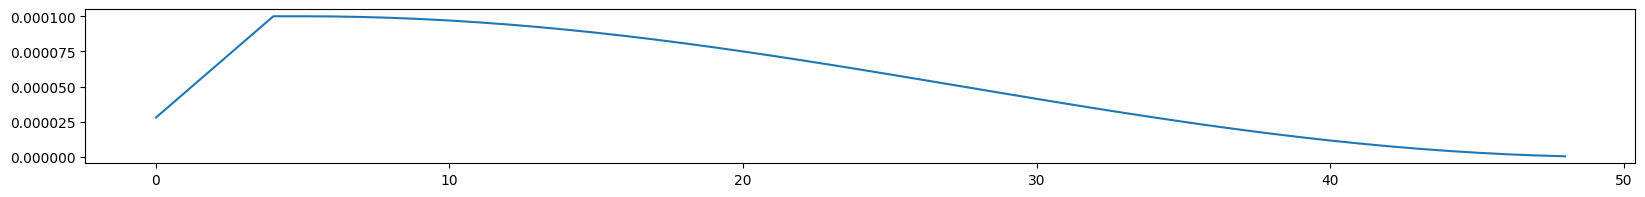

In [99]:
# model = CNN(backbone=backbone, pretrained=False)
model = TimmSED(
            base_model_name=config.base_model_name,
            config=config,
            pretrained=config.pretrained,
            num_classes=config.num_classes,
            in_channels=config.in_channels
        )


rcParams['figure.figsize'] = 20, 2

optimizer = AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

lrs = []
for epoch in range(1, n_epochs):
    scheduler_warmup.step()
    lrs.append(optimizer.param_groups[0]["lr"])

plt.plot(range(len(lrs)), lrs)

In [100]:

def train_fold():
    logger = init_logger(log_file=os.path.join(output_folder, exp_name, f"{fold}.log"))

    logger.info("=" * 90)
    logger.info(f"Fold {fold} Training")
    logger.info("=" * 90)

    trn_df = df[df['fold'] != fold].reset_index(drop=True)
    val_df = df[df['fold'] == fold].reset_index(drop=True)
#     print(trn_df.shape)
    logger.info(trn_df.shape)
    logger.info(trn_df['primary_label'].value_counts())
    logger.info(val_df.shape)
    logger.info(val_df['primary_label'].value_counts())


    # trn_dataset = BirdDataset(df=trn_df.reset_index(drop=True), transform=transforms_train, add_secondary_labels=True, mode='train')
    # v_ds = BirdDataset(df=val_df.reset_index(drop=True), transform=transforms_val, add_secondary_labels=True, mode='valid')
    trn_dataset = BirdDataset(df=trn_df.reset_index(drop=True), transform=transforms_train, add_secondary_labels=True)
    v_ds = BirdDataset(df=val_df.reset_index(drop=True), transform=transforms_val, add_secondary_labels=True)

    train_loader = torch.utils.data.DataLoader(trn_dataset, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=num_workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(v_ds, shuffle=False, batch_size=batch_size, drop_last=False, num_workers=num_workers, pin_memory=True)

    if CNN_:
        model = CNN(backbone=backbone, pretrained=True).to(device)
    else:
        model = TimmSED(
                base_model_name=config.base_model_name,
                config=config,
                pretrained=config.pretrained,
                num_classes=config.num_classes,
                in_channels=config.in_channels
            ).to(device)
    
    optimizer = AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    patience = early_stopping
    best_score = 0.0
    n_patience = 0

    for epoch in range(1, n_epochs + 1):
        # if epoch==5: break
        print(time.ctime(), 'Epoch:', epoch)

        scheduler_warmup.step(epoch-1)

        train_scores, train_losses_avg = train_one_epoch(model, train_loader, optimizer, scaler,epoch)
        train_scores_str = metrics_to_string(train_scores, "Train")
        train_info = f"Epoch {epoch} - Train loss: {train_losses_avg:.4f}, {train_scores_str}"
        logger.info(train_info)

        val_scores, val_losses_avg = valid_one_epoch(model, val_loader)
        val_scores_str = metrics_to_string(val_scores, f"Valid")
        val_info = f"Epoch {epoch} - Valid loss: {val_losses_avg:.4f}, {val_scores_str}"
        logger.info(val_info)

        val_score = val_scores["ROC"]

        is_better = val_score > best_score
        best_score = max(val_score, best_score)

        if is_better:
            state = {
                "epoch": epoch,
                "state_dict": model.state_dict(),
                "best_loss": best_score,
                "optimizer": optimizer.state_dict(),
            }
            logger.info(
                f"Epoch {epoch} - Save Best Score: {best_score:.4f} Model\n")
            torch.save(
                state,
                os.path.join(output_folder, exp_name, f"{fold}.bin")
            )
            n_patience = 0
        else:
            n_patience += 1
            logger.info(
                f"Valid loss didn't improve last {n_patience} epochs.\n")

        if n_patience >= patience:
            logger.info(
                "Early stop, Training End.\n")
            state = {
                "epoch": epoch,
                "state_dict": model.state_dict(),
                "best_loss": best_score,
                "optimizer": optimizer.state_dict(),
            }
            torch.save(
                state,
                os.path.join(output_folder, exp_name, f"final_{fold}.bin")
            )
            break

    del model
    torch.cuda.empty_cache()
    gc.collect()

base  0.9701

In [101]:
train_fold()

Fold 2 Training
Fold 2 Training
Fold 2 Training
(45683, 4)
(45683, 4)
(45683, 4)
primary_label
eaywag1    3553
commoo3    3165
eurcoo     3018
barswa     2381
comsan     2298
           ... 
wynlau1       6
nilfly2       6
integr        5
niwpig1       4
paisto1       4
Name: count, Length: 182, dtype: int64
primary_label
eaywag1    3553
commoo3    3165
eurcoo     3018
barswa     2381
comsan     2298
           ... 
wynlau1       6
nilfly2       6
integr        5
niwpig1       4
paisto1       4
Name: count, Length: 182, dtype: int64
primary_label
eaywag1    3553
commoo3    3165
eurcoo     3018
barswa     2381
comsan     2298
           ... 
wynlau1       6
nilfly2       6
integr        5
niwpig1       4
paisto1       4
Name: count, Length: 182, dtype: int64
(11452, 4)
(11452, 4)
(11452, 4)
primary_label
eaywag1    889
commoo3    791
eurcoo     754
barswa     595
comsan     574
          ... 
wbbfly1      1
inpher1      1
scamin3      1
niwpig1      1
malwoo1      1
Name: count, Length:

load from local
load from local 2
323 323
Thu May 16 11:08:07 2024 Epoch: 1


100%|██████████| 713/713 [02:52<00:00,  4.14it/s, grad=1.59e+3, loss=0.502, lr=1e-5]
Epoch 1 - Train loss: 0.5019, Train cmAP_1 : 0.4407, Train cmAP_5 : 0.6516, Train ROC : 0.4571, 
Epoch 1 - Train loss: 0.5019, Train cmAP_1 : 0.4407, Train cmAP_5 : 0.6516, Train ROC : 0.4571, 
Epoch 1 - Train loss: 0.5019, Train cmAP_1 : 0.4407, Train cmAP_5 : 0.6516, Train ROC : 0.4571, 
100%|██████████| 179/179 [00:47<00:00,  3.75it/s, loss=0.0419]
Epoch 1 - Valid loss: 0.0419, Valid cmAP_1 : 0.1200, Valid cmAP_5 : 0.2950, Valid ROC : 0.6243, 
Epoch 1 - Valid loss: 0.0419, Valid cmAP_1 : 0.1200, Valid cmAP_5 : 0.2950, Valid ROC : 0.6243, 
Epoch 1 - Valid loss: 0.0419, Valid cmAP_1 : 0.1200, Valid cmAP_5 : 0.2950, Valid ROC : 0.6243, 
Epoch 1 - Save Best Score: 0.6243 Model

Epoch 1 - Save Best Score: 0.6243 Model

Epoch 1 - Save Best Score: 0.6243 Model



Thu May 16 11:12:02 2024 Epoch: 2


100%|██████████| 713/713 [02:55<00:00,  4.06it/s, grad=1.07e+3, loss=0.0325, lr=2.8e-5]
Epoch 2 - Train loss: 0.0325, Train cmAP_1 : 0.4489, Train cmAP_5 : 0.6709, Train ROC : 0.6940, 
Epoch 2 - Train loss: 0.0325, Train cmAP_1 : 0.4489, Train cmAP_5 : 0.6709, Train ROC : 0.6940, 
Epoch 2 - Train loss: 0.0325, Train cmAP_1 : 0.4489, Train cmAP_5 : 0.6709, Train ROC : 0.6940, 
100%|██████████| 179/179 [00:49<00:00,  3.59it/s, loss=0.0238]
Epoch 2 - Valid loss: 0.0238, Valid cmAP_1 : 0.2413, Valid cmAP_5 : 0.4183, Valid ROC : 0.8687, 
Epoch 2 - Valid loss: 0.0238, Valid cmAP_1 : 0.2413, Valid cmAP_5 : 0.4183, Valid ROC : 0.8687, 
Epoch 2 - Valid loss: 0.0238, Valid cmAP_1 : 0.2413, Valid cmAP_5 : 0.4183, Valid ROC : 0.8687, 
Epoch 2 - Save Best Score: 0.8687 Model

Epoch 2 - Save Best Score: 0.8687 Model

Epoch 2 - Save Best Score: 0.8687 Model



Thu May 16 11:16:01 2024 Epoch: 3


100%|██████████| 713/713 [03:01<00:00,  3.93it/s, grad=1.67e+3, loss=0.0253, lr=4.6e-5]
Epoch 3 - Train loss: 0.0253, Train cmAP_1 : 0.4479, Train cmAP_5 : 0.6698, Train ROC : 0.8726, 
Epoch 3 - Train loss: 0.0253, Train cmAP_1 : 0.4479, Train cmAP_5 : 0.6698, Train ROC : 0.8726, 
Epoch 3 - Train loss: 0.0253, Train cmAP_1 : 0.4479, Train cmAP_5 : 0.6698, Train ROC : 0.8726, 
100%|██████████| 179/179 [00:49<00:00,  3.64it/s, loss=0.0167]
Epoch 3 - Valid loss: 0.0167, Valid cmAP_1 : 0.3820, Valid cmAP_5 : 0.5502, Valid ROC : 0.9352, 
Epoch 3 - Valid loss: 0.0167, Valid cmAP_1 : 0.3820, Valid cmAP_5 : 0.5502, Valid ROC : 0.9352, 
Epoch 3 - Valid loss: 0.0167, Valid cmAP_1 : 0.3820, Valid cmAP_5 : 0.5502, Valid ROC : 0.9352, 
Epoch 3 - Save Best Score: 0.9352 Model

Epoch 3 - Save Best Score: 0.9352 Model

Epoch 3 - Save Best Score: 0.9352 Model



Thu May 16 11:20:06 2024 Epoch: 4


100%|██████████| 713/713 [03:02<00:00,  3.91it/s, grad=1.65e+3, loss=0.0227, lr=6.4e-5]
Epoch 4 - Train loss: 0.0227, Train cmAP_1 : 0.4824, Train cmAP_5 : 0.6910, Train ROC : 0.9248, 
Epoch 4 - Train loss: 0.0227, Train cmAP_1 : 0.4824, Train cmAP_5 : 0.6910, Train ROC : 0.9248, 
Epoch 4 - Train loss: 0.0227, Train cmAP_1 : 0.4824, Train cmAP_5 : 0.6910, Train ROC : 0.9248, 
100%|██████████| 179/179 [00:51<00:00,  3.47it/s, loss=0.0147]
Epoch 4 - Valid loss: 0.0147, Valid cmAP_1 : 0.4528, Valid cmAP_5 : 0.6136, Valid ROC : 0.9553, 
Epoch 4 - Valid loss: 0.0147, Valid cmAP_1 : 0.4528, Valid cmAP_5 : 0.6136, Valid ROC : 0.9553, 
Epoch 4 - Valid loss: 0.0147, Valid cmAP_1 : 0.4528, Valid cmAP_5 : 0.6136, Valid ROC : 0.9553, 
Epoch 4 - Save Best Score: 0.9553 Model

Epoch 4 - Save Best Score: 0.9553 Model

Epoch 4 - Save Best Score: 0.9553 Model



Thu May 16 11:24:13 2024 Epoch: 5


100%|██████████| 713/713 [02:56<00:00,  4.05it/s, grad=1.15e+3, loss=0.0215, lr=8.2e-5]
Epoch 5 - Train loss: 0.0215, Train cmAP_1 : 0.5039, Train cmAP_5 : 0.7078, Train ROC : 0.9458, 
Epoch 5 - Train loss: 0.0215, Train cmAP_1 : 0.5039, Train cmAP_5 : 0.7078, Train ROC : 0.9458, 
Epoch 5 - Train loss: 0.0215, Train cmAP_1 : 0.5039, Train cmAP_5 : 0.7078, Train ROC : 0.9458, 
100%|██████████| 179/179 [00:59<00:00,  3.00it/s, loss=0.013] 
Epoch 5 - Valid loss: 0.0130, Valid cmAP_1 : 0.5147, Valid cmAP_5 : 0.6649, Valid ROC : 0.9666, 
Epoch 5 - Valid loss: 0.0130, Valid cmAP_1 : 0.5147, Valid cmAP_5 : 0.6649, Valid ROC : 0.9666, 
Epoch 5 - Valid loss: 0.0130, Valid cmAP_1 : 0.5147, Valid cmAP_5 : 0.6649, Valid ROC : 0.9666, 
Epoch 5 - Save Best Score: 0.9666 Model

Epoch 5 - Save Best Score: 0.9666 Model

Epoch 5 - Save Best Score: 0.9666 Model



Thu May 16 11:28:23 2024 Epoch: 6


100%|██████████| 713/713 [03:02<00:00,  3.91it/s, grad=3.49e+3, loss=0.0201, lr=0.0001]
Epoch 6 - Train loss: 0.0201, Train cmAP_1 : 0.5082, Train cmAP_5 : 0.7166, Train ROC : 0.9560, 
Epoch 6 - Train loss: 0.0201, Train cmAP_1 : 0.5082, Train cmAP_5 : 0.7166, Train ROC : 0.9560, 
Epoch 6 - Train loss: 0.0201, Train cmAP_1 : 0.5082, Train cmAP_5 : 0.7166, Train ROC : 0.9560, 
100%|██████████| 179/179 [00:53<00:00,  3.37it/s, loss=0.0118]
Epoch 6 - Valid loss: 0.0118, Valid cmAP_1 : 0.5515, Valid cmAP_5 : 0.6940, Valid ROC : 0.9735, 
Epoch 6 - Valid loss: 0.0118, Valid cmAP_1 : 0.5515, Valid cmAP_5 : 0.6940, Valid ROC : 0.9735, 
Epoch 6 - Valid loss: 0.0118, Valid cmAP_1 : 0.5515, Valid cmAP_5 : 0.6940, Valid ROC : 0.9735, 
Epoch 6 - Save Best Score: 0.9735 Model

Epoch 6 - Save Best Score: 0.9735 Model

Epoch 6 - Save Best Score: 0.9735 Model



Thu May 16 11:32:32 2024 Epoch: 7


100%|██████████| 713/713 [02:53<00:00,  4.10it/s, grad=3.07e+3, loss=0.0193, lr=0.0001]
Epoch 7 - Train loss: 0.0193, Train cmAP_1 : 0.5078, Train cmAP_5 : 0.7153, Train ROC : 0.9655, 
Epoch 7 - Train loss: 0.0193, Train cmAP_1 : 0.5078, Train cmAP_5 : 0.7153, Train ROC : 0.9655, 
Epoch 7 - Train loss: 0.0193, Train cmAP_1 : 0.5078, Train cmAP_5 : 0.7153, Train ROC : 0.9655, 
100%|██████████| 179/179 [00:53<00:00,  3.36it/s, loss=0.0112]
Epoch 7 - Valid loss: 0.0112, Valid cmAP_1 : 0.5725, Valid cmAP_5 : 0.7102, Valid ROC : 0.9764, 
Epoch 7 - Valid loss: 0.0112, Valid cmAP_1 : 0.5725, Valid cmAP_5 : 0.7102, Valid ROC : 0.9764, 
Epoch 7 - Valid loss: 0.0112, Valid cmAP_1 : 0.5725, Valid cmAP_5 : 0.7102, Valid ROC : 0.9764, 
Epoch 7 - Save Best Score: 0.9764 Model

Epoch 7 - Save Best Score: 0.9764 Model

Epoch 7 - Save Best Score: 0.9764 Model



Thu May 16 11:36:33 2024 Epoch: 8


100%|██████████| 713/713 [03:08<00:00,  3.78it/s, grad=2.2e+3, loss=0.0188, lr=9.95e-5] 
Epoch 8 - Train loss: 0.0188, Train cmAP_1 : 0.4971, Train cmAP_5 : 0.7087, Train ROC : 0.9593, 
Epoch 8 - Train loss: 0.0188, Train cmAP_1 : 0.4971, Train cmAP_5 : 0.7087, Train ROC : 0.9593, 
Epoch 8 - Train loss: 0.0188, Train cmAP_1 : 0.4971, Train cmAP_5 : 0.7087, Train ROC : 0.9593, 
100%|██████████| 179/179 [00:47<00:00,  3.77it/s, loss=0.0111]
Epoch 8 - Valid loss: 0.0111, Valid cmAP_1 : 0.5875, Valid cmAP_5 : 0.7218, Valid ROC : 0.9785, 
Epoch 8 - Valid loss: 0.0111, Valid cmAP_1 : 0.5875, Valid cmAP_5 : 0.7218, Valid ROC : 0.9785, 
Epoch 8 - Valid loss: 0.0111, Valid cmAP_1 : 0.5875, Valid cmAP_5 : 0.7218, Valid ROC : 0.9785, 
Epoch 8 - Save Best Score: 0.9785 Model

Epoch 8 - Save Best Score: 0.9785 Model

Epoch 8 - Save Best Score: 0.9785 Model



Thu May 16 11:40:43 2024 Epoch: 9


100%|██████████| 713/713 [03:06<00:00,  3.82it/s, grad=5.48e+3, loss=0.0185, lr=9.89e-5]
Epoch 9 - Train loss: 0.0185, Train cmAP_1 : 0.5088, Train cmAP_5 : 0.7133, Train ROC : 0.9722, 
Epoch 9 - Train loss: 0.0185, Train cmAP_1 : 0.5088, Train cmAP_5 : 0.7133, Train ROC : 0.9722, 
Epoch 9 - Train loss: 0.0185, Train cmAP_1 : 0.5088, Train cmAP_5 : 0.7133, Train ROC : 0.9722, 
100%|██████████| 179/179 [00:49<00:00,  3.61it/s, loss=0.0107]
Epoch 9 - Valid loss: 0.0107, Valid cmAP_1 : 0.6007, Valid cmAP_5 : 0.7327, Valid ROC : 0.9797, 
Epoch 9 - Valid loss: 0.0107, Valid cmAP_1 : 0.6007, Valid cmAP_5 : 0.7327, Valid ROC : 0.9797, 
Epoch 9 - Valid loss: 0.0107, Valid cmAP_1 : 0.6007, Valid cmAP_5 : 0.7327, Valid ROC : 0.9797, 
Epoch 9 - Save Best Score: 0.9797 Model

Epoch 9 - Save Best Score: 0.9797 Model

Epoch 9 - Save Best Score: 0.9797 Model



Thu May 16 11:44:54 2024 Epoch: 10


100%|██████████| 713/713 [03:04<00:00,  3.86it/s, grad=5.83e+3, loss=0.0183, lr=9.81e-5]
Epoch 10 - Train loss: 0.0183, Train cmAP_1 : 0.5315, Train cmAP_5 : 0.7346, Train ROC : 0.9807, 
Epoch 10 - Train loss: 0.0183, Train cmAP_1 : 0.5315, Train cmAP_5 : 0.7346, Train ROC : 0.9807, 
Epoch 10 - Train loss: 0.0183, Train cmAP_1 : 0.5315, Train cmAP_5 : 0.7346, Train ROC : 0.9807, 
100%|██████████| 179/179 [00:52<00:00,  3.40it/s, loss=0.0105]
Epoch 10 - Valid loss: 0.0105, Valid cmAP_1 : 0.6075, Valid cmAP_5 : 0.7367, Valid ROC : 0.9804, 
Epoch 10 - Valid loss: 0.0105, Valid cmAP_1 : 0.6075, Valid cmAP_5 : 0.7367, Valid ROC : 0.9804, 
Epoch 10 - Valid loss: 0.0105, Valid cmAP_1 : 0.6075, Valid cmAP_5 : 0.7367, Valid ROC : 0.9804, 
Epoch 10 - Save Best Score: 0.9804 Model

Epoch 10 - Save Best Score: 0.9804 Model

Epoch 10 - Save Best Score: 0.9804 Model



Thu May 16 11:49:05 2024 Epoch: 11


100%|██████████| 713/713 [03:24<00:00,  3.49it/s, grad=3.98e+3, loss=0.0179, lr=9.7e-5]
Epoch 11 - Train loss: 0.0179, Train cmAP_1 : 0.4931, Train cmAP_5 : 0.6990, Train ROC : 0.9768, 
Epoch 11 - Train loss: 0.0179, Train cmAP_1 : 0.4931, Train cmAP_5 : 0.6990, Train ROC : 0.9768, 
Epoch 11 - Train loss: 0.0179, Train cmAP_1 : 0.4931, Train cmAP_5 : 0.6990, Train ROC : 0.9768, 
100%|██████████| 179/179 [01:02<00:00,  2.85it/s, loss=0.0106]
Epoch 11 - Valid loss: 0.0106, Valid cmAP_1 : 0.6148, Valid cmAP_5 : 0.7416, Valid ROC : 0.9809, 
Epoch 11 - Valid loss: 0.0106, Valid cmAP_1 : 0.6148, Valid cmAP_5 : 0.7416, Valid ROC : 0.9809, 
Epoch 11 - Valid loss: 0.0106, Valid cmAP_1 : 0.6148, Valid cmAP_5 : 0.7416, Valid ROC : 0.9809, 
Epoch 11 - Save Best Score: 0.9809 Model

Epoch 11 - Save Best Score: 0.9809 Model

Epoch 11 - Save Best Score: 0.9809 Model



Thu May 16 11:53:46 2024 Epoch: 12


100%|██████████| 713/713 [03:35<00:00,  3.31it/s, grad=8.13e+3, loss=0.0181, lr=9.57e-5]
Epoch 12 - Train loss: 0.0181, Train cmAP_1 : 0.4709, Train cmAP_5 : 0.6880, Train ROC : 0.9758, 
Epoch 12 - Train loss: 0.0181, Train cmAP_1 : 0.4709, Train cmAP_5 : 0.6880, Train ROC : 0.9758, 
Epoch 12 - Train loss: 0.0181, Train cmAP_1 : 0.4709, Train cmAP_5 : 0.6880, Train ROC : 0.9758, 
100%|██████████| 179/179 [00:54<00:00,  3.26it/s, loss=0.0105]
Epoch 12 - Valid loss: 0.0105, Valid cmAP_1 : 0.6237, Valid cmAP_5 : 0.7483, Valid ROC : 0.9819, 
Epoch 12 - Valid loss: 0.0105, Valid cmAP_1 : 0.6237, Valid cmAP_5 : 0.7483, Valid ROC : 0.9819, 
Epoch 12 - Valid loss: 0.0105, Valid cmAP_1 : 0.6237, Valid cmAP_5 : 0.7483, Valid ROC : 0.9819, 
Epoch 12 - Save Best Score: 0.9819 Model

Epoch 12 - Save Best Score: 0.9819 Model

Epoch 12 - Save Best Score: 0.9819 Model



Thu May 16 11:58:30 2024 Epoch: 13


100%|██████████| 713/713 [06:41<00:00,  1.77it/s, grad=7.65e+3, loss=0.0178, lr=9.41e-5]  
Epoch 13 - Train loss: 0.0178, Train cmAP_1 : 0.5264, Train cmAP_5 : 0.7292, Train ROC : 0.9750, 
Epoch 13 - Train loss: 0.0178, Train cmAP_1 : 0.5264, Train cmAP_5 : 0.7292, Train ROC : 0.9750, 
Epoch 13 - Train loss: 0.0178, Train cmAP_1 : 0.5264, Train cmAP_5 : 0.7292, Train ROC : 0.9750, 
100%|██████████| 179/179 [00:50<00:00,  3.53it/s, loss=0.0105]
Epoch 13 - Valid loss: 0.0105, Valid cmAP_1 : 0.6279, Valid cmAP_5 : 0.7506, Valid ROC : 0.9813, 
Epoch 13 - Valid loss: 0.0105, Valid cmAP_1 : 0.6279, Valid cmAP_5 : 0.7506, Valid ROC : 0.9813, 
Epoch 13 - Valid loss: 0.0105, Valid cmAP_1 : 0.6279, Valid cmAP_5 : 0.7506, Valid ROC : 0.9813, 
Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.



Thu May 16 12:06:16 2024 Epoch: 14


100%|██████████| 713/713 [03:24<00:00,  3.49it/s, grad=8.1e+3, loss=0.0178, lr=9.24e-5] 
Epoch 14 - Train loss: 0.0178, Train cmAP_1 : 0.5006, Train cmAP_5 : 0.7187, Train ROC : 0.9728, 
Epoch 14 - Train loss: 0.0178, Train cmAP_1 : 0.5006, Train cmAP_5 : 0.7187, Train ROC : 0.9728, 
Epoch 14 - Train loss: 0.0178, Train cmAP_1 : 0.5006, Train cmAP_5 : 0.7187, Train ROC : 0.9728, 
100%|██████████| 179/179 [00:49<00:00,  3.64it/s, loss=0.0105]
Epoch 14 - Valid loss: 0.0105, Valid cmAP_1 : 0.6316, Valid cmAP_5 : 0.7538, Valid ROC : 0.9822, 
Epoch 14 - Valid loss: 0.0105, Valid cmAP_1 : 0.6316, Valid cmAP_5 : 0.7538, Valid ROC : 0.9822, 
Epoch 14 - Valid loss: 0.0105, Valid cmAP_1 : 0.6316, Valid cmAP_5 : 0.7538, Valid ROC : 0.9822, 
Epoch 14 - Save Best Score: 0.9822 Model

Epoch 14 - Save Best Score: 0.9822 Model

Epoch 14 - Save Best Score: 0.9822 Model



Thu May 16 12:10:44 2024 Epoch: 15


100%|██████████| 713/713 [03:05<00:00,  3.85it/s, grad=2.33e+4, loss=0.0174, lr=9.05e-5]
Epoch 15 - Train loss: 0.0174, Train cmAP_1 : 0.4828, Train cmAP_5 : 0.7062, Train ROC : 0.9757, 
Epoch 15 - Train loss: 0.0174, Train cmAP_1 : 0.4828, Train cmAP_5 : 0.7062, Train ROC : 0.9757, 
Epoch 15 - Train loss: 0.0174, Train cmAP_1 : 0.4828, Train cmAP_5 : 0.7062, Train ROC : 0.9757, 
100%|██████████| 179/179 [00:53<00:00,  3.36it/s, loss=0.00961]
Epoch 15 - Valid loss: 0.0096, Valid cmAP_1 : 0.6414, Valid cmAP_5 : 0.7600, Valid ROC : 0.9832, 
Epoch 15 - Valid loss: 0.0096, Valid cmAP_1 : 0.6414, Valid cmAP_5 : 0.7600, Valid ROC : 0.9832, 
Epoch 15 - Valid loss: 0.0096, Valid cmAP_1 : 0.6414, Valid cmAP_5 : 0.7600, Valid ROC : 0.9832, 
Epoch 15 - Save Best Score: 0.9832 Model

Epoch 15 - Save Best Score: 0.9832 Model

Epoch 15 - Save Best Score: 0.9832 Model



Thu May 16 12:14:56 2024 Epoch: 16


100%|██████████| 713/713 [03:33<00:00,  3.34it/s, grad=1.72e+4, loss=0.0173, lr=8.83e-5]
Epoch 16 - Train loss: 0.0173, Train cmAP_1 : 0.5051, Train cmAP_5 : 0.7142, Train ROC : 0.9734, 
Epoch 16 - Train loss: 0.0173, Train cmAP_1 : 0.5051, Train cmAP_5 : 0.7142, Train ROC : 0.9734, 
Epoch 16 - Train loss: 0.0173, Train cmAP_1 : 0.5051, Train cmAP_5 : 0.7142, Train ROC : 0.9734, 
100%|██████████| 179/179 [00:54<00:00,  3.29it/s, loss=0.00946]
Epoch 16 - Valid loss: 0.0095, Valid cmAP_1 : 0.6467, Valid cmAP_5 : 0.7637, Valid ROC : 0.9836, 
Epoch 16 - Valid loss: 0.0095, Valid cmAP_1 : 0.6467, Valid cmAP_5 : 0.7637, Valid ROC : 0.9836, 
Epoch 16 - Valid loss: 0.0095, Valid cmAP_1 : 0.6467, Valid cmAP_5 : 0.7637, Valid ROC : 0.9836, 
Epoch 16 - Save Best Score: 0.9836 Model

Epoch 16 - Save Best Score: 0.9836 Model

Epoch 16 - Save Best Score: 0.9836 Model



Thu May 16 12:19:38 2024 Epoch: 17


100%|██████████| 713/713 [03:06<00:00,  3.82it/s, grad=3.26e+4, loss=0.0174, lr=8.6e-5]
Epoch 17 - Train loss: 0.0174, Train cmAP_1 : 0.5231, Train cmAP_5 : 0.7233, Train ROC : 0.9750, 
Epoch 17 - Train loss: 0.0174, Train cmAP_1 : 0.5231, Train cmAP_5 : 0.7233, Train ROC : 0.9750, 
Epoch 17 - Train loss: 0.0174, Train cmAP_1 : 0.5231, Train cmAP_5 : 0.7233, Train ROC : 0.9750, 
100%|██████████| 179/179 [00:53<00:00,  3.34it/s, loss=0.00954]
Epoch 17 - Valid loss: 0.0095, Valid cmAP_1 : 0.6469, Valid cmAP_5 : 0.7638, Valid ROC : 0.9835, 
Epoch 17 - Valid loss: 0.0095, Valid cmAP_1 : 0.6469, Valid cmAP_5 : 0.7638, Valid ROC : 0.9835, 
Epoch 17 - Valid loss: 0.0095, Valid cmAP_1 : 0.6469, Valid cmAP_5 : 0.7638, Valid ROC : 0.9835, 
Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.



Thu May 16 12:23:51 2024 Epoch: 18


100%|██████████| 713/713 [03:17<00:00,  3.62it/s, grad=3.45e+4, loss=0.0173, lr=8.35e-5]
Epoch 18 - Train loss: 0.0173, Train cmAP_1 : 0.4770, Train cmAP_5 : 0.6997, Train ROC : 0.9798, 
Epoch 18 - Train loss: 0.0173, Train cmAP_1 : 0.4770, Train cmAP_5 : 0.6997, Train ROC : 0.9798, 
Epoch 18 - Train loss: 0.0173, Train cmAP_1 : 0.4770, Train cmAP_5 : 0.6997, Train ROC : 0.9798, 
100%|██████████| 179/179 [00:58<00:00,  3.05it/s, loss=0.00959]
Epoch 18 - Valid loss: 0.0096, Valid cmAP_1 : 0.6478, Valid cmAP_5 : 0.7652, Valid ROC : 0.9837, 
Epoch 18 - Valid loss: 0.0096, Valid cmAP_1 : 0.6478, Valid cmAP_5 : 0.7652, Valid ROC : 0.9837, 
Epoch 18 - Valid loss: 0.0096, Valid cmAP_1 : 0.6478, Valid cmAP_5 : 0.7652, Valid ROC : 0.9837, 
Epoch 18 - Save Best Score: 0.9837 Model

Epoch 18 - Save Best Score: 0.9837 Model

Epoch 18 - Save Best Score: 0.9837 Model



Thu May 16 12:28:21 2024 Epoch: 19


100%|██████████| 713/713 [03:14<00:00,  3.66it/s, grad=3.09e+4, loss=0.0172, lr=8.08e-5]
Epoch 19 - Train loss: 0.0172, Train cmAP_1 : 0.5361, Train cmAP_5 : 0.7285, Train ROC : 0.9775, 
Epoch 19 - Train loss: 0.0172, Train cmAP_1 : 0.5361, Train cmAP_5 : 0.7285, Train ROC : 0.9775, 
Epoch 19 - Train loss: 0.0172, Train cmAP_1 : 0.5361, Train cmAP_5 : 0.7285, Train ROC : 0.9775, 
100%|██████████| 179/179 [00:56<00:00,  3.19it/s, loss=0.0101]
Epoch 19 - Valid loss: 0.0101, Valid cmAP_1 : 0.6468, Valid cmAP_5 : 0.7639, Valid ROC : 0.9828, 
Epoch 19 - Valid loss: 0.0101, Valid cmAP_1 : 0.6468, Valid cmAP_5 : 0.7639, Valid ROC : 0.9828, 
Epoch 19 - Valid loss: 0.0101, Valid cmAP_1 : 0.6468, Valid cmAP_5 : 0.7639, Valid ROC : 0.9828, 
Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.



Thu May 16 12:32:46 2024 Epoch: 20


100%|██████████| 713/713 [03:13<00:00,  3.69it/s, grad=6.06e+4, loss=0.0171, lr=7.8e-5]
Epoch 20 - Train loss: 0.0171, Train cmAP_1 : 0.5372, Train cmAP_5 : 0.7332, Train ROC : 0.9778, 
Epoch 20 - Train loss: 0.0171, Train cmAP_1 : 0.5372, Train cmAP_5 : 0.7332, Train ROC : 0.9778, 
Epoch 20 - Train loss: 0.0171, Train cmAP_1 : 0.5372, Train cmAP_5 : 0.7332, Train ROC : 0.9778, 
100%|██████████| 179/179 [01:03<00:00,  2.81it/s, loss=0.00977]
Epoch 20 - Valid loss: 0.0098, Valid cmAP_1 : 0.6517, Valid cmAP_5 : 0.7668, Valid ROC : 0.9836, 
Epoch 20 - Valid loss: 0.0098, Valid cmAP_1 : 0.6517, Valid cmAP_5 : 0.7668, Valid ROC : 0.9836, 
Epoch 20 - Valid loss: 0.0098, Valid cmAP_1 : 0.6517, Valid cmAP_5 : 0.7668, Valid ROC : 0.9836, 
Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.



Thu May 16 12:37:16 2024 Epoch: 21


100%|██████████| 713/713 [03:06<00:00,  3.83it/s, grad=1.08e+5, loss=0.00905, lr=7.5e-5]
Epoch 21 - Train loss: 0.0090, Train cmAP_1 : 0.5722, Train cmAP_5 : 0.6419, Train ROC : 0.9870, 
Epoch 21 - Train loss: 0.0090, Train cmAP_1 : 0.5722, Train cmAP_5 : 0.6419, Train ROC : 0.9870, 
Epoch 21 - Train loss: 0.0090, Train cmAP_1 : 0.5722, Train cmAP_5 : 0.6419, Train ROC : 0.9870, 
100%|██████████| 179/179 [00:50<00:00,  3.57it/s, loss=0.00868]
Epoch 21 - Valid loss: 0.0087, Valid cmAP_1 : 0.6546, Valid cmAP_5 : 0.7693, Valid ROC : 0.9848, 
Epoch 21 - Valid loss: 0.0087, Valid cmAP_1 : 0.6546, Valid cmAP_5 : 0.7693, Valid ROC : 0.9848, 
Epoch 21 - Valid loss: 0.0087, Valid cmAP_1 : 0.6546, Valid cmAP_5 : 0.7693, Valid ROC : 0.9848, 
Epoch 21 - Save Best Score: 0.9848 Model

Epoch 21 - Save Best Score: 0.9848 Model

Epoch 21 - Save Best Score: 0.9848 Model



Thu May 16 12:41:27 2024 Epoch: 22


100%|██████████| 713/713 [03:15<00:00,  3.65it/s, grad=9.36e+4, loss=0.00888, lr=7.19e-5]
Epoch 22 - Train loss: 0.0089, Train cmAP_1 : 0.5734, Train cmAP_5 : 0.6429, Train ROC : 0.9872, 
Epoch 22 - Train loss: 0.0089, Train cmAP_1 : 0.5734, Train cmAP_5 : 0.6429, Train ROC : 0.9872, 
Epoch 22 - Train loss: 0.0089, Train cmAP_1 : 0.5734, Train cmAP_5 : 0.6429, Train ROC : 0.9872, 
100%|██████████| 179/179 [00:47<00:00,  3.80it/s, loss=0.0086] 
Epoch 22 - Valid loss: 0.0086, Valid cmAP_1 : 0.6565, Valid cmAP_5 : 0.7704, Valid ROC : 0.9854, 
Epoch 22 - Valid loss: 0.0086, Valid cmAP_1 : 0.6565, Valid cmAP_5 : 0.7704, Valid ROC : 0.9854, 
Epoch 22 - Valid loss: 0.0086, Valid cmAP_1 : 0.6565, Valid cmAP_5 : 0.7704, Valid ROC : 0.9854, 
Epoch 22 - Save Best Score: 0.9854 Model

Epoch 22 - Save Best Score: 0.9854 Model

Epoch 22 - Save Best Score: 0.9854 Model



Thu May 16 12:45:44 2024 Epoch: 23


100%|██████████| 713/713 [04:21<00:00,  2.73it/s, grad=1.86e+5, loss=0.00875, lr=6.87e-5]
Epoch 23 - Train loss: 0.0087, Train cmAP_1 : 0.5763, Train cmAP_5 : 0.6456, Train ROC : 0.9875, 
Epoch 23 - Train loss: 0.0087, Train cmAP_1 : 0.5763, Train cmAP_5 : 0.6456, Train ROC : 0.9875, 
Epoch 23 - Train loss: 0.0087, Train cmAP_1 : 0.5763, Train cmAP_5 : 0.6456, Train ROC : 0.9875, 
100%|██████████| 179/179 [00:45<00:00,  3.90it/s, loss=0.00858]
Epoch 23 - Valid loss: 0.0086, Valid cmAP_1 : 0.6584, Valid cmAP_5 : 0.7718, Valid ROC : 0.9852, 
Epoch 23 - Valid loss: 0.0086, Valid cmAP_1 : 0.6584, Valid cmAP_5 : 0.7718, Valid ROC : 0.9852, 
Epoch 23 - Valid loss: 0.0086, Valid cmAP_1 : 0.6584, Valid cmAP_5 : 0.7718, Valid ROC : 0.9852, 
Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.



Thu May 16 12:51:05 2024 Epoch: 24


100%|██████████| 713/713 [03:21<00:00,  3.53it/s, grad=1.98e+5, loss=0.00869, lr=6.55e-5]
Epoch 24 - Train loss: 0.0087, Train cmAP_1 : 0.5780, Train cmAP_5 : 0.6468, Train ROC : 0.9874, 
Epoch 24 - Train loss: 0.0087, Train cmAP_1 : 0.5780, Train cmAP_5 : 0.6468, Train ROC : 0.9874, 
Epoch 24 - Train loss: 0.0087, Train cmAP_1 : 0.5780, Train cmAP_5 : 0.6468, Train ROC : 0.9874, 
100%|██████████| 179/179 [00:58<00:00,  3.08it/s, loss=0.00853]
Epoch 24 - Valid loss: 0.0085, Valid cmAP_1 : 0.6559, Valid cmAP_5 : 0.7706, Valid ROC : 0.9853, 
Epoch 24 - Valid loss: 0.0085, Valid cmAP_1 : 0.6559, Valid cmAP_5 : 0.7706, Valid ROC : 0.9853, 
Epoch 24 - Valid loss: 0.0085, Valid cmAP_1 : 0.6559, Valid cmAP_5 : 0.7706, Valid ROC : 0.9853, 
Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.



Thu May 16 12:55:39 2024 Epoch: 25


100%|██████████| 713/713 [03:34<00:00,  3.33it/s, grad=9.11e+4, loss=0.00865, lr=6.21e-5]
Epoch 25 - Train loss: 0.0087, Train cmAP_1 : 0.5757, Train cmAP_5 : 0.6455, Train ROC : 0.9879, 
Epoch 25 - Train loss: 0.0087, Train cmAP_1 : 0.5757, Train cmAP_5 : 0.6455, Train ROC : 0.9879, 
Epoch 25 - Train loss: 0.0087, Train cmAP_1 : 0.5757, Train cmAP_5 : 0.6455, Train ROC : 0.9879, 
100%|██████████| 179/179 [03:28<00:00,  1.17s/it, loss=0.00848]
Epoch 25 - Valid loss: 0.0085, Valid cmAP_1 : 0.6600, Valid cmAP_5 : 0.7729, Valid ROC : 0.9852, 
Epoch 25 - Valid loss: 0.0085, Valid cmAP_1 : 0.6600, Valid cmAP_5 : 0.7729, Valid ROC : 0.9852, 
Epoch 25 - Valid loss: 0.0085, Valid cmAP_1 : 0.6600, Valid cmAP_5 : 0.7729, Valid ROC : 0.9852, 
Valid loss didn't improve last 3 epochs.

Valid loss didn't improve last 3 epochs.

Valid loss didn't improve last 3 epochs.



Thu May 16 13:02:56 2024 Epoch: 26


100%|██████████| 713/713 [03:02<00:00,  3.90it/s, grad=9.02e+4, loss=0.00858, lr=5.87e-5]
Epoch 26 - Train loss: 0.0086, Train cmAP_1 : 0.5804, Train cmAP_5 : 0.6486, Train ROC : 0.9876, 
Epoch 26 - Train loss: 0.0086, Train cmAP_1 : 0.5804, Train cmAP_5 : 0.6486, Train ROC : 0.9876, 
Epoch 26 - Train loss: 0.0086, Train cmAP_1 : 0.5804, Train cmAP_5 : 0.6486, Train ROC : 0.9876, 
100%|██████████| 179/179 [00:57<00:00,  3.13it/s, loss=0.00846]
Epoch 26 - Valid loss: 0.0085, Valid cmAP_1 : 0.6587, Valid cmAP_5 : 0.7722, Valid ROC : 0.9853, 
Epoch 26 - Valid loss: 0.0085, Valid cmAP_1 : 0.6587, Valid cmAP_5 : 0.7722, Valid ROC : 0.9853, 
Epoch 26 - Valid loss: 0.0085, Valid cmAP_1 : 0.6587, Valid cmAP_5 : 0.7722, Valid ROC : 0.9853, 
Valid loss didn't improve last 4 epochs.

Valid loss didn't improve last 4 epochs.

Valid loss didn't improve last 4 epochs.



Thu May 16 13:07:10 2024 Epoch: 27


100%|██████████| 713/713 [03:38<00:00,  3.27it/s, grad=1.79e+5, loss=0.00853, lr=5.52e-5]
Epoch 27 - Train loss: 0.0085, Train cmAP_1 : 0.5881, Train cmAP_5 : 0.6557, Train ROC : 0.9882, 
Epoch 27 - Train loss: 0.0085, Train cmAP_1 : 0.5881, Train cmAP_5 : 0.6557, Train ROC : 0.9882, 
Epoch 27 - Train loss: 0.0085, Train cmAP_1 : 0.5881, Train cmAP_5 : 0.6557, Train ROC : 0.9882, 
100%|██████████| 179/179 [01:02<00:00,  2.87it/s, loss=0.00847]
Epoch 27 - Valid loss: 0.0085, Valid cmAP_1 : 0.6601, Valid cmAP_5 : 0.7731, Valid ROC : 0.9853, 
Epoch 27 - Valid loss: 0.0085, Valid cmAP_1 : 0.6601, Valid cmAP_5 : 0.7731, Valid ROC : 0.9853, 
Epoch 27 - Valid loss: 0.0085, Valid cmAP_1 : 0.6601, Valid cmAP_5 : 0.7731, Valid ROC : 0.9853, 
Valid loss didn't improve last 5 epochs.

Valid loss didn't improve last 5 epochs.

Valid loss didn't improve last 5 epochs.



Thu May 16 13:12:06 2024 Epoch: 28


100%|██████████| 713/713 [03:22<00:00,  3.52it/s, grad=1.98e+5, loss=0.00848, lr=5.17e-5]
Epoch 28 - Train loss: 0.0085, Train cmAP_1 : 0.5893, Train cmAP_5 : 0.6571, Train ROC : 0.9884, 
Epoch 28 - Train loss: 0.0085, Train cmAP_1 : 0.5893, Train cmAP_5 : 0.6571, Train ROC : 0.9884, 
Epoch 28 - Train loss: 0.0085, Train cmAP_1 : 0.5893, Train cmAP_5 : 0.6571, Train ROC : 0.9884, 
100%|██████████| 179/179 [01:01<00:00,  2.93it/s, loss=0.00842]
Epoch 28 - Valid loss: 0.0084, Valid cmAP_1 : 0.6612, Valid cmAP_5 : 0.7741, Valid ROC : 0.9855, 
Epoch 28 - Valid loss: 0.0084, Valid cmAP_1 : 0.6612, Valid cmAP_5 : 0.7741, Valid ROC : 0.9855, 
Epoch 28 - Valid loss: 0.0084, Valid cmAP_1 : 0.6612, Valid cmAP_5 : 0.7741, Valid ROC : 0.9855, 
Epoch 28 - Save Best Score: 0.9855 Model

Epoch 28 - Save Best Score: 0.9855 Model

Epoch 28 - Save Best Score: 0.9855 Model



Thu May 16 13:16:44 2024 Epoch: 29


100%|██████████| 713/713 [03:22<00:00,  3.52it/s, grad=1.81e+5, loss=0.00846, lr=4.83e-5]
Epoch 29 - Train loss: 0.0085, Train cmAP_1 : 0.5898, Train cmAP_5 : 0.6568, Train ROC : 0.9877, 
Epoch 29 - Train loss: 0.0085, Train cmAP_1 : 0.5898, Train cmAP_5 : 0.6568, Train ROC : 0.9877, 
Epoch 29 - Train loss: 0.0085, Train cmAP_1 : 0.5898, Train cmAP_5 : 0.6568, Train ROC : 0.9877, 
100%|██████████| 179/179 [01:00<00:00,  2.95it/s, loss=0.00842]
Epoch 29 - Valid loss: 0.0084, Valid cmAP_1 : 0.6615, Valid cmAP_5 : 0.7741, Valid ROC : 0.9853, 
Epoch 29 - Valid loss: 0.0084, Valid cmAP_1 : 0.6615, Valid cmAP_5 : 0.7741, Valid ROC : 0.9853, 
Epoch 29 - Valid loss: 0.0084, Valid cmAP_1 : 0.6615, Valid cmAP_5 : 0.7741, Valid ROC : 0.9853, 
Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.



Thu May 16 13:21:22 2024 Epoch: 30


100%|██████████| 713/713 [03:48<00:00,  3.12it/s, grad=2.4e+5, loss=0.00841, lr=4.48e-5] 
Epoch 30 - Train loss: 0.0084, Train cmAP_1 : 0.5896, Train cmAP_5 : 0.6578, Train ROC : 0.9881, 
Epoch 30 - Train loss: 0.0084, Train cmAP_1 : 0.5896, Train cmAP_5 : 0.6578, Train ROC : 0.9881, 
Epoch 30 - Train loss: 0.0084, Train cmAP_1 : 0.5896, Train cmAP_5 : 0.6578, Train ROC : 0.9881, 
100%|██████████| 179/179 [01:10<00:00,  2.54it/s, loss=0.00841]
Epoch 30 - Valid loss: 0.0084, Valid cmAP_1 : 0.6622, Valid cmAP_5 : 0.7746, Valid ROC : 0.9855, 
Epoch 30 - Valid loss: 0.0084, Valid cmAP_1 : 0.6622, Valid cmAP_5 : 0.7746, Valid ROC : 0.9855, 
Epoch 30 - Valid loss: 0.0084, Valid cmAP_1 : 0.6622, Valid cmAP_5 : 0.7746, Valid ROC : 0.9855, 
Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.



Thu May 16 13:26:35 2024 Epoch: 31


100%|██████████| 713/713 [03:56<00:00,  3.01it/s, grad=1.79e+5, loss=0.00834, lr=4.13e-5]
Epoch 31 - Train loss: 0.0083, Train cmAP_1 : 0.5929, Train cmAP_5 : 0.6608, Train ROC : 0.9887, 
Epoch 31 - Train loss: 0.0083, Train cmAP_1 : 0.5929, Train cmAP_5 : 0.6608, Train ROC : 0.9887, 
Epoch 31 - Train loss: 0.0083, Train cmAP_1 : 0.5929, Train cmAP_5 : 0.6608, Train ROC : 0.9887, 
100%|██████████| 179/179 [00:56<00:00,  3.16it/s, loss=0.00844]
Epoch 31 - Valid loss: 0.0084, Valid cmAP_1 : 0.6617, Valid cmAP_5 : 0.7740, Valid ROC : 0.9856, 
Epoch 31 - Valid loss: 0.0084, Valid cmAP_1 : 0.6617, Valid cmAP_5 : 0.7740, Valid ROC : 0.9856, 
Epoch 31 - Valid loss: 0.0084, Valid cmAP_1 : 0.6617, Valid cmAP_5 : 0.7740, Valid ROC : 0.9856, 
Epoch 31 - Save Best Score: 0.9856 Model

Epoch 31 - Save Best Score: 0.9856 Model

Epoch 31 - Save Best Score: 0.9856 Model



Thu May 16 13:31:43 2024 Epoch: 32


100%|██████████| 713/713 [03:27<00:00,  3.43it/s, grad=1.99e+5, loss=0.00839, lr=3.79e-5]
Epoch 32 - Train loss: 0.0084, Train cmAP_1 : 0.5876, Train cmAP_5 : 0.6556, Train ROC : 0.9884, 
Epoch 32 - Train loss: 0.0084, Train cmAP_1 : 0.5876, Train cmAP_5 : 0.6556, Train ROC : 0.9884, 
Epoch 32 - Train loss: 0.0084, Train cmAP_1 : 0.5876, Train cmAP_5 : 0.6556, Train ROC : 0.9884, 
100%|██████████| 179/179 [00:57<00:00,  3.13it/s, loss=0.00839]
Epoch 32 - Valid loss: 0.0084, Valid cmAP_1 : 0.6614, Valid cmAP_5 : 0.7742, Valid ROC : 0.9854, 
Epoch 32 - Valid loss: 0.0084, Valid cmAP_1 : 0.6614, Valid cmAP_5 : 0.7742, Valid ROC : 0.9854, 
Epoch 32 - Valid loss: 0.0084, Valid cmAP_1 : 0.6614, Valid cmAP_5 : 0.7742, Valid ROC : 0.9854, 
Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.



Thu May 16 13:36:22 2024 Epoch: 33


100%|██████████| 713/713 [03:24<00:00,  3.49it/s, grad=1.76e+5, loss=0.00836, lr=3.45e-5]
Epoch 33 - Train loss: 0.0084, Train cmAP_1 : 0.5924, Train cmAP_5 : 0.6602, Train ROC : 0.9887, 
Epoch 33 - Train loss: 0.0084, Train cmAP_1 : 0.5924, Train cmAP_5 : 0.6602, Train ROC : 0.9887, 
Epoch 33 - Train loss: 0.0084, Train cmAP_1 : 0.5924, Train cmAP_5 : 0.6602, Train ROC : 0.9887, 
100%|██████████| 179/179 [00:58<00:00,  3.07it/s, loss=0.00841]
Epoch 33 - Valid loss: 0.0084, Valid cmAP_1 : 0.6646, Valid cmAP_5 : 0.7764, Valid ROC : 0.9853, 
Epoch 33 - Valid loss: 0.0084, Valid cmAP_1 : 0.6646, Valid cmAP_5 : 0.7764, Valid ROC : 0.9853, 
Epoch 33 - Valid loss: 0.0084, Valid cmAP_1 : 0.6646, Valid cmAP_5 : 0.7764, Valid ROC : 0.9853, 
Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.



Thu May 16 13:40:58 2024 Epoch: 34


100%|██████████| 713/713 [03:20<00:00,  3.55it/s, grad=2.47e+5, loss=0.00836, lr=3.13e-5]
Epoch 34 - Train loss: 0.0084, Train cmAP_1 : 0.5924, Train cmAP_5 : 0.6591, Train ROC : 0.9880, 
Epoch 34 - Train loss: 0.0084, Train cmAP_1 : 0.5924, Train cmAP_5 : 0.6591, Train ROC : 0.9880, 
Epoch 34 - Train loss: 0.0084, Train cmAP_1 : 0.5924, Train cmAP_5 : 0.6591, Train ROC : 0.9880, 
100%|██████████| 179/179 [00:55<00:00,  3.21it/s, loss=0.00837]
Epoch 34 - Valid loss: 0.0084, Valid cmAP_1 : 0.6636, Valid cmAP_5 : 0.7757, Valid ROC : 0.9856, 
Epoch 34 - Valid loss: 0.0084, Valid cmAP_1 : 0.6636, Valid cmAP_5 : 0.7757, Valid ROC : 0.9856, 
Epoch 34 - Valid loss: 0.0084, Valid cmAP_1 : 0.6636, Valid cmAP_5 : 0.7757, Valid ROC : 0.9856, 
Epoch 34 - Save Best Score: 0.9856 Model

Epoch 34 - Save Best Score: 0.9856 Model

Epoch 34 - Save Best Score: 0.9856 Model



Thu May 16 13:45:29 2024 Epoch: 35


100%|██████████| 713/713 [03:28<00:00,  3.42it/s, grad=2.12e+5, loss=0.00829, lr=2.81e-5]
Epoch 35 - Train loss: 0.0083, Train cmAP_1 : 0.5912, Train cmAP_5 : 0.6588, Train ROC : 0.9888, 
Epoch 35 - Train loss: 0.0083, Train cmAP_1 : 0.5912, Train cmAP_5 : 0.6588, Train ROC : 0.9888, 
Epoch 35 - Train loss: 0.0083, Train cmAP_1 : 0.5912, Train cmAP_5 : 0.6588, Train ROC : 0.9888, 
100%|██████████| 179/179 [01:03<00:00,  2.81it/s, loss=0.00841]
Epoch 35 - Valid loss: 0.0084, Valid cmAP_1 : 0.6628, Valid cmAP_5 : 0.7747, Valid ROC : 0.9855, 
Epoch 35 - Valid loss: 0.0084, Valid cmAP_1 : 0.6628, Valid cmAP_5 : 0.7747, Valid ROC : 0.9855, 
Epoch 35 - Valid loss: 0.0084, Valid cmAP_1 : 0.6628, Valid cmAP_5 : 0.7747, Valid ROC : 0.9855, 
Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.



Thu May 16 13:50:16 2024 Epoch: 36


100%|██████████| 713/713 [03:49<00:00,  3.10it/s, grad=1.86e+5, loss=0.00824, lr=2.5e-5]
Epoch 36 - Train loss: 0.0082, Train cmAP_1 : 0.5964, Train cmAP_5 : 0.6641, Train ROC : 0.9888, 
Epoch 36 - Train loss: 0.0082, Train cmAP_1 : 0.5964, Train cmAP_5 : 0.6641, Train ROC : 0.9888, 
Epoch 36 - Train loss: 0.0082, Train cmAP_1 : 0.5964, Train cmAP_5 : 0.6641, Train ROC : 0.9888, 
100%|██████████| 179/179 [01:01<00:00,  2.91it/s, loss=0.00836]
Epoch 36 - Valid loss: 0.0084, Valid cmAP_1 : 0.6652, Valid cmAP_5 : 0.7765, Valid ROC : 0.9855, 
Epoch 36 - Valid loss: 0.0084, Valid cmAP_1 : 0.6652, Valid cmAP_5 : 0.7765, Valid ROC : 0.9855, 
Epoch 36 - Valid loss: 0.0084, Valid cmAP_1 : 0.6652, Valid cmAP_5 : 0.7765, Valid ROC : 0.9855, 
Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.



Thu May 16 13:55:21 2024 Epoch: 37


100%|██████████| 713/713 [03:51<00:00,  3.09it/s, grad=1.6e+5, loss=0.00822, lr=2.2e-5] 
Epoch 37 - Train loss: 0.0082, Train cmAP_1 : 0.5998, Train cmAP_5 : 0.6660, Train ROC : 0.9890, 
Epoch 37 - Train loss: 0.0082, Train cmAP_1 : 0.5998, Train cmAP_5 : 0.6660, Train ROC : 0.9890, 
Epoch 37 - Train loss: 0.0082, Train cmAP_1 : 0.5998, Train cmAP_5 : 0.6660, Train ROC : 0.9890, 
100%|██████████| 179/179 [03:51<00:00,  1.29s/it, loss=0.00837]
Epoch 37 - Valid loss: 0.0084, Valid cmAP_1 : 0.6637, Valid cmAP_5 : 0.7758, Valid ROC : 0.9857, 
Epoch 37 - Valid loss: 0.0084, Valid cmAP_1 : 0.6637, Valid cmAP_5 : 0.7758, Valid ROC : 0.9857, 
Epoch 37 - Valid loss: 0.0084, Valid cmAP_1 : 0.6637, Valid cmAP_5 : 0.7758, Valid ROC : 0.9857, 
Epoch 37 - Save Best Score: 0.9857 Model

Epoch 37 - Save Best Score: 0.9857 Model

Epoch 37 - Save Best Score: 0.9857 Model



Thu May 16 14:03:18 2024 Epoch: 38


100%|██████████| 713/713 [03:49<00:00,  3.10it/s, grad=1.11e+5, loss=0.00827, lr=1.92e-5]
Epoch 38 - Train loss: 0.0083, Train cmAP_1 : 0.5979, Train cmAP_5 : 0.6648, Train ROC : 0.9886, 
Epoch 38 - Train loss: 0.0083, Train cmAP_1 : 0.5979, Train cmAP_5 : 0.6648, Train ROC : 0.9886, 
Epoch 38 - Train loss: 0.0083, Train cmAP_1 : 0.5979, Train cmAP_5 : 0.6648, Train ROC : 0.9886, 
100%|██████████| 179/179 [01:07<00:00,  2.66it/s, loss=0.00838]
Epoch 38 - Valid loss: 0.0084, Valid cmAP_1 : 0.6631, Valid cmAP_5 : 0.7752, Valid ROC : 0.9855, 
Epoch 38 - Valid loss: 0.0084, Valid cmAP_1 : 0.6631, Valid cmAP_5 : 0.7752, Valid ROC : 0.9855, 
Epoch 38 - Valid loss: 0.0084, Valid cmAP_1 : 0.6631, Valid cmAP_5 : 0.7752, Valid ROC : 0.9855, 
Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.



Thu May 16 14:08:29 2024 Epoch: 39


100%|██████████| 713/713 [03:42<00:00,  3.20it/s, grad=9.7e+4, loss=0.00822, lr=1.65e-5] 
Epoch 39 - Train loss: 0.0082, Train cmAP_1 : 0.5928, Train cmAP_5 : 0.6614, Train ROC : 0.9889, 
Epoch 39 - Train loss: 0.0082, Train cmAP_1 : 0.5928, Train cmAP_5 : 0.6614, Train ROC : 0.9889, 
Epoch 39 - Train loss: 0.0082, Train cmAP_1 : 0.5928, Train cmAP_5 : 0.6614, Train ROC : 0.9889, 
100%|██████████| 179/179 [01:00<00:00,  2.95it/s, loss=0.00836]
Epoch 39 - Valid loss: 0.0084, Valid cmAP_1 : 0.6645, Valid cmAP_5 : 0.7761, Valid ROC : 0.9856, 
Epoch 39 - Valid loss: 0.0084, Valid cmAP_1 : 0.6645, Valid cmAP_5 : 0.7761, Valid ROC : 0.9856, 
Epoch 39 - Valid loss: 0.0084, Valid cmAP_1 : 0.6645, Valid cmAP_5 : 0.7761, Valid ROC : 0.9856, 
Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.



Thu May 16 14:13:27 2024 Epoch: 40


100%|██████████| 713/713 [03:57<00:00,  3.00it/s, grad=1.55e+5, loss=0.00822, lr=1.4e-5]
Epoch 40 - Train loss: 0.0082, Train cmAP_1 : 0.5949, Train cmAP_5 : 0.6627, Train ROC : 0.9890, 
Epoch 40 - Train loss: 0.0082, Train cmAP_1 : 0.5949, Train cmAP_5 : 0.6627, Train ROC : 0.9890, 
Epoch 40 - Train loss: 0.0082, Train cmAP_1 : 0.5949, Train cmAP_5 : 0.6627, Train ROC : 0.9890, 
100%|██████████| 179/179 [00:58<00:00,  3.04it/s, loss=0.00838]
Epoch 40 - Valid loss: 0.0084, Valid cmAP_1 : 0.6641, Valid cmAP_5 : 0.7760, Valid ROC : 0.9857, 
Epoch 40 - Valid loss: 0.0084, Valid cmAP_1 : 0.6641, Valid cmAP_5 : 0.7760, Valid ROC : 0.9857, 
Epoch 40 - Valid loss: 0.0084, Valid cmAP_1 : 0.6641, Valid cmAP_5 : 0.7760, Valid ROC : 0.9857, 
Epoch 40 - Save Best Score: 0.9857 Model

Epoch 40 - Save Best Score: 0.9857 Model

Epoch 40 - Save Best Score: 0.9857 Model



Thu May 16 14:18:38 2024 Epoch: 41


100%|██████████| 713/713 [03:43<00:00,  3.19it/s, grad=1.78e+5, loss=0.00822, lr=1.17e-5]
Epoch 41 - Train loss: 0.0082, Train cmAP_1 : 0.5989, Train cmAP_5 : 0.6660, Train ROC : 0.9884, 
Epoch 41 - Train loss: 0.0082, Train cmAP_1 : 0.5989, Train cmAP_5 : 0.6660, Train ROC : 0.9884, 
Epoch 41 - Train loss: 0.0082, Train cmAP_1 : 0.5989, Train cmAP_5 : 0.6660, Train ROC : 0.9884, 
100%|██████████| 179/179 [00:52<00:00,  3.42it/s, loss=0.00836]
Epoch 41 - Valid loss: 0.0084, Valid cmAP_1 : 0.6658, Valid cmAP_5 : 0.7767, Valid ROC : 0.9855, 
Epoch 41 - Valid loss: 0.0084, Valid cmAP_1 : 0.6658, Valid cmAP_5 : 0.7767, Valid ROC : 0.9855, 
Epoch 41 - Valid loss: 0.0084, Valid cmAP_1 : 0.6658, Valid cmAP_5 : 0.7767, Valid ROC : 0.9855, 
Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.



Thu May 16 14:23:27 2024 Epoch: 42


100%|██████████| 713/713 [03:08<00:00,  3.79it/s, grad=1.17e+5, loss=0.00821, lr=9.55e-6]
Epoch 42 - Train loss: 0.0082, Train cmAP_1 : 0.5998, Train cmAP_5 : 0.6670, Train ROC : 0.9886, 
Epoch 42 - Train loss: 0.0082, Train cmAP_1 : 0.5998, Train cmAP_5 : 0.6670, Train ROC : 0.9886, 
Epoch 42 - Train loss: 0.0082, Train cmAP_1 : 0.5998, Train cmAP_5 : 0.6670, Train ROC : 0.9886, 
100%|██████████| 179/179 [00:56<00:00,  3.16it/s, loss=0.00838]
Epoch 42 - Valid loss: 0.0084, Valid cmAP_1 : 0.6640, Valid cmAP_5 : 0.7758, Valid ROC : 0.9857, 
Epoch 42 - Valid loss: 0.0084, Valid cmAP_1 : 0.6640, Valid cmAP_5 : 0.7758, Valid ROC : 0.9857, 
Epoch 42 - Valid loss: 0.0084, Valid cmAP_1 : 0.6640, Valid cmAP_5 : 0.7758, Valid ROC : 0.9857, 
Epoch 42 - Save Best Score: 0.9857 Model

Epoch 42 - Save Best Score: 0.9857 Model

Epoch 42 - Save Best Score: 0.9857 Model



Thu May 16 14:27:47 2024 Epoch: 43


100%|██████████| 713/713 [03:04<00:00,  3.86it/s, grad=2.1e+5, loss=0.00819, lr=7.6e-6] 
Epoch 43 - Train loss: 0.0082, Train cmAP_1 : 0.5967, Train cmAP_5 : 0.6644, Train ROC : 0.9891, 
Epoch 43 - Train loss: 0.0082, Train cmAP_1 : 0.5967, Train cmAP_5 : 0.6644, Train ROC : 0.9891, 
Epoch 43 - Train loss: 0.0082, Train cmAP_1 : 0.5967, Train cmAP_5 : 0.6644, Train ROC : 0.9891, 
100%|██████████| 179/179 [01:00<00:00,  2.97it/s, loss=0.00836]
Epoch 43 - Valid loss: 0.0084, Valid cmAP_1 : 0.6637, Valid cmAP_5 : 0.7758, Valid ROC : 0.9857, 
Epoch 43 - Valid loss: 0.0084, Valid cmAP_1 : 0.6637, Valid cmAP_5 : 0.7758, Valid ROC : 0.9857, 
Epoch 43 - Valid loss: 0.0084, Valid cmAP_1 : 0.6637, Valid cmAP_5 : 0.7758, Valid ROC : 0.9857, 
Epoch 43 - Save Best Score: 0.9857 Model

Epoch 43 - Save Best Score: 0.9857 Model

Epoch 43 - Save Best Score: 0.9857 Model



Thu May 16 14:32:06 2024 Epoch: 44


100%|██████████| 713/713 [03:35<00:00,  3.31it/s, grad=2.31e+5, loss=0.00821, lr=5.85e-6]
Epoch 44 - Train loss: 0.0082, Train cmAP_1 : 0.5997, Train cmAP_5 : 0.6664, Train ROC : 0.9889, 
Epoch 44 - Train loss: 0.0082, Train cmAP_1 : 0.5997, Train cmAP_5 : 0.6664, Train ROC : 0.9889, 
Epoch 44 - Train loss: 0.0082, Train cmAP_1 : 0.5997, Train cmAP_5 : 0.6664, Train ROC : 0.9889, 
100%|██████████| 179/179 [00:56<00:00,  3.18it/s, loss=0.00838]
Epoch 44 - Valid loss: 0.0084, Valid cmAP_1 : 0.6651, Valid cmAP_5 : 0.7764, Valid ROC : 0.9856, 
Epoch 44 - Valid loss: 0.0084, Valid cmAP_1 : 0.6651, Valid cmAP_5 : 0.7764, Valid ROC : 0.9856, 
Epoch 44 - Valid loss: 0.0084, Valid cmAP_1 : 0.6651, Valid cmAP_5 : 0.7764, Valid ROC : 0.9856, 
Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.



Thu May 16 14:36:52 2024 Epoch: 45


100%|██████████| 713/713 [03:37<00:00,  3.28it/s, grad=2.11e+5, loss=0.0082, lr=4.32e-6] 
Epoch 45 - Train loss: 0.0082, Train cmAP_1 : 0.5966, Train cmAP_5 : 0.6630, Train ROC : 0.9889, 
Epoch 45 - Train loss: 0.0082, Train cmAP_1 : 0.5966, Train cmAP_5 : 0.6630, Train ROC : 0.9889, 
Epoch 45 - Train loss: 0.0082, Train cmAP_1 : 0.5966, Train cmAP_5 : 0.6630, Train ROC : 0.9889, 
100%|██████████| 179/179 [00:58<00:00,  3.04it/s, loss=0.00835]
Epoch 45 - Valid loss: 0.0084, Valid cmAP_1 : 0.6645, Valid cmAP_5 : 0.7763, Valid ROC : 0.9856, 
Epoch 45 - Valid loss: 0.0084, Valid cmAP_1 : 0.6645, Valid cmAP_5 : 0.7763, Valid ROC : 0.9856, 
Epoch 45 - Valid loss: 0.0084, Valid cmAP_1 : 0.6645, Valid cmAP_5 : 0.7763, Valid ROC : 0.9856, 
Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.



Thu May 16 14:41:43 2024 Epoch: 46


100%|██████████| 713/713 [03:45<00:00,  3.16it/s, grad=1.73e+5, loss=0.00821, lr=3.02e-6]
Epoch 46 - Train loss: 0.0082, Train cmAP_1 : 0.5966, Train cmAP_5 : 0.6640, Train ROC : 0.9889, 
Epoch 46 - Train loss: 0.0082, Train cmAP_1 : 0.5966, Train cmAP_5 : 0.6640, Train ROC : 0.9889, 
Epoch 46 - Train loss: 0.0082, Train cmAP_1 : 0.5966, Train cmAP_5 : 0.6640, Train ROC : 0.9889, 
100%|██████████| 179/179 [01:08<00:00,  2.63it/s, loss=0.00836]
Epoch 46 - Valid loss: 0.0084, Valid cmAP_1 : 0.6658, Valid cmAP_5 : 0.7771, Valid ROC : 0.9856, 
Epoch 46 - Valid loss: 0.0084, Valid cmAP_1 : 0.6658, Valid cmAP_5 : 0.7771, Valid ROC : 0.9856, 
Epoch 46 - Valid loss: 0.0084, Valid cmAP_1 : 0.6658, Valid cmAP_5 : 0.7771, Valid ROC : 0.9856, 
Valid loss didn't improve last 3 epochs.

Valid loss didn't improve last 3 epochs.

Valid loss didn't improve last 3 epochs.



Thu May 16 14:46:51 2024 Epoch: 47


100%|██████████| 713/713 [03:39<00:00,  3.25it/s, grad=2.3e+5, loss=0.00818, lr=1.94e-6] 
Epoch 47 - Train loss: 0.0082, Train cmAP_1 : 0.5970, Train cmAP_5 : 0.6641, Train ROC : 0.9886, 
Epoch 47 - Train loss: 0.0082, Train cmAP_1 : 0.5970, Train cmAP_5 : 0.6641, Train ROC : 0.9886, 
Epoch 47 - Train loss: 0.0082, Train cmAP_1 : 0.5970, Train cmAP_5 : 0.6641, Train ROC : 0.9886, 
100%|██████████| 179/179 [01:08<00:00,  2.63it/s, loss=0.00841]
Epoch 47 - Valid loss: 0.0084, Valid cmAP_1 : 0.6637, Valid cmAP_5 : 0.7754, Valid ROC : 0.9856, 
Epoch 47 - Valid loss: 0.0084, Valid cmAP_1 : 0.6637, Valid cmAP_5 : 0.7754, Valid ROC : 0.9856, 
Epoch 47 - Valid loss: 0.0084, Valid cmAP_1 : 0.6637, Valid cmAP_5 : 0.7754, Valid ROC : 0.9856, 
Valid loss didn't improve last 4 epochs.

Valid loss didn't improve last 4 epochs.

Valid loss didn't improve last 4 epochs.



Thu May 16 14:51:52 2024 Epoch: 48


100%|██████████| 713/713 [03:52<00:00,  3.07it/s, grad=2.2e+5, loss=0.00821, lr=1.09e-6] 
Epoch 48 - Train loss: 0.0082, Train cmAP_1 : 0.5993, Train cmAP_5 : 0.6662, Train ROC : 0.9886, 
Epoch 48 - Train loss: 0.0082, Train cmAP_1 : 0.5993, Train cmAP_5 : 0.6662, Train ROC : 0.9886, 
Epoch 48 - Train loss: 0.0082, Train cmAP_1 : 0.5993, Train cmAP_5 : 0.6662, Train ROC : 0.9886, 
100%|██████████| 179/179 [01:07<00:00,  2.66it/s, loss=0.00837]
Epoch 48 - Valid loss: 0.0084, Valid cmAP_1 : 0.6645, Valid cmAP_5 : 0.7761, Valid ROC : 0.9858, 
Epoch 48 - Valid loss: 0.0084, Valid cmAP_1 : 0.6645, Valid cmAP_5 : 0.7761, Valid ROC : 0.9858, 
Epoch 48 - Valid loss: 0.0084, Valid cmAP_1 : 0.6645, Valid cmAP_5 : 0.7761, Valid ROC : 0.9858, 
Epoch 48 - Save Best Score: 0.9858 Model

Epoch 48 - Save Best Score: 0.9858 Model

Epoch 48 - Save Best Score: 0.9858 Model



Thu May 16 14:57:06 2024 Epoch: 49


100%|██████████| 713/713 [03:45<00:00,  3.17it/s, grad=2.39e+5, loss=0.00816, lr=4.87e-7]
Epoch 49 - Train loss: 0.0082, Train cmAP_1 : 0.6029, Train cmAP_5 : 0.6684, Train ROC : 0.9885, 
Epoch 49 - Train loss: 0.0082, Train cmAP_1 : 0.6029, Train cmAP_5 : 0.6684, Train ROC : 0.9885, 
Epoch 49 - Train loss: 0.0082, Train cmAP_1 : 0.6029, Train cmAP_5 : 0.6684, Train ROC : 0.9885, 
100%|██████████| 179/179 [01:10<00:00,  2.55it/s, loss=0.00837]
Epoch 49 - Valid loss: 0.0084, Valid cmAP_1 : 0.6638, Valid cmAP_5 : 0.7761, Valid ROC : 0.9856, 
Epoch 49 - Valid loss: 0.0084, Valid cmAP_1 : 0.6638, Valid cmAP_5 : 0.7761, Valid ROC : 0.9856, 
Epoch 49 - Valid loss: 0.0084, Valid cmAP_1 : 0.6638, Valid cmAP_5 : 0.7761, Valid ROC : 0.9856, 
Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.

Valid loss didn't improve last 1 epochs.



Thu May 16 15:02:15 2024 Epoch: 50


100%|██████████| 713/713 [05:32<00:00,  2.14it/s, grad=2.04e+5, loss=0.00821, lr=1.22e-7]  
Epoch 50 - Train loss: 0.0082, Train cmAP_1 : 0.5947, Train cmAP_5 : 0.6623, Train ROC : 0.9889, 
Epoch 50 - Train loss: 0.0082, Train cmAP_1 : 0.5947, Train cmAP_5 : 0.6623, Train ROC : 0.9889, 
Epoch 50 - Train loss: 0.0082, Train cmAP_1 : 0.5947, Train cmAP_5 : 0.6623, Train ROC : 0.9889, 
100%|██████████| 179/179 [01:00<00:00,  2.95it/s, loss=0.00835]
Epoch 50 - Valid loss: 0.0084, Valid cmAP_1 : 0.6645, Valid cmAP_5 : 0.7761, Valid ROC : 0.9856, 
Epoch 50 - Valid loss: 0.0084, Valid cmAP_1 : 0.6645, Valid cmAP_5 : 0.7761, Valid ROC : 0.9856, 
Epoch 50 - Valid loss: 0.0084, Valid cmAP_1 : 0.6645, Valid cmAP_5 : 0.7761, Valid ROC : 0.9856, 
Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.

Valid loss didn't improve last 2 epochs.



In [102]:
# /home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/input/birdclef-2024/train_audio/litgre1

In [103]:
import torchlibrosa

In [104]:
torchlibrosa.SpecAugmentation

torchlibrosa.augmentation.SpecAugmentation